In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os
import copy
import holidays
import datetime as dt
from datetime import timedelta
os.getcwd()
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

import shap
shap.initjs()

pd.set_option('display.max_columns', 30)

In [3]:
# read data

#stops_pre_covid = pd.read_parquet("~/Downloads/all_stops_ungrouped/stops_pre_covid.parquet")
#stops_during_covid = pd.read_parquet("~/Downloads/all_stops_ungrouped/stops_during_covid.parquet")
stops_post_covid = pd.read_parquet("~/Downloads/all_stops_ungrouped/rush_stops_post_covid.parquet")


df = stops_post_covid


# read in network characteristics
network_char = pd.read_csv("./data/network_char.csv")

# read in punctuality data
punct2019_1 = pd.read_csv("./data/Punctuality_2019_part1.csv", sep = ";")
punct2019_2 = pd.read_csv("./data/Punctuality_2019_part2.csv", sep = ";")
punct2020_1 = pd.read_csv("./data/Punctuality_2020_part1.csv", sep = ";")
punct2020_2 = pd.read_csv("./data/Punctuality_2020_part2.csv", sep = ";")
punct2021_1 = pd.read_csv("./data/Punctuality_2021_part1.csv", sep = ";")
punct2021_2 = pd.read_csv("./data/Punctuality_2021_part2.csv", sep = ";")
punct2022_1 = pd.read_csv("./data/Punctuality_2022_part1.csv", sep = ";")
punct2022_2 = pd.read_csv("./data/Punctuality_2022_part2.csv", sep = ";")
punct2023 = pd.read_csv("./data/Punctuality_2023.csv", sep = ";")
all_punct = pd.concat([punct2019_1, punct2019_2, punct2020_1, punct2020_2, punct2021_1, punct2021_2, punct2022_1, punct2022_2, punct2023], axis = 0)
all_punct = all_punct[all_punct['TRAIN_ID'].notna()].reset_index()

# read in justifications data
justifs = pd.read_csv("~/Downloads/Studie P-treinen/Extract justifications.csv", sep = ";", encoding='latin-1')
justifs['p_resp'] = justifs['trno_resp'].apply(lambda x: 1 if ((x >= 7000) & (x <= 8999)) else 0)

# count how many times a train was justified (by all / by P-train / by normal train)
trains_justifs_count = justifs.groupby(['REF_TOD_IMPACTED_TRAIN']).agg(all_justif_count=('REF_JUS_ID', 'count'),
                                                                       p_justif_count=('p_resp', 'sum')).reset_index()
trains_justifs_count['normal_justif_count'] = trains_justifs_count['all_justif_count'] - trains_justifs_count['p_justif_count']

# add justifications columns to punctuality dataframe
punct_justifs = all_punct.merge(trains_justifs_count, left_on = 'TRAIN_ID', right_on='REF_TOD_IMPACTED_TRAIN', how = "left")
punct_justifs = punct_justifs.drop(columns='REF_TOD_IMPACTED_TRAIN')
punct_justifs['all_justif_count'].fillna(0, inplace=True)
punct_justifs['p_justif_count'].fillna(0, inplace=True)
punct_justifs['normal_justif_count'].fillna(0, inplace=True)


Columns (28,30,34,35,37,38,39,40,41,42,43,50) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
# add column to indicate if train suffered a small delay (>90 sec) at the stations
df['small_delay'] = df['EH_ARR'].apply(lambda x: 1 if x >= 90 else 0)

# add column to indicate which line the station is located on
lines = pd.unique(df['LINE']).tolist()
for line in lines:
    df[f"{line}"] = df['LINE'].apply(lambda x: 1 if x == line else 0)

# check
df

REF_TOD_TRAIN_ID  TRAIN_NUMBER TRAIN_DEPARTURE_DATE  REF_PTCAR_NO   
0                30429876         13255           2022-06-05           810  \
1                30430881          6067           2022-06-05           442   
2                30541622          3678           2022-06-23           215   
3                30430858          5286           2022-06-05           956   
4                30539760          7679           2022-06-23           418   
...                   ...           ...                  ...           ...   
4603482          32033017          2066           2023-02-18           318   
4603483          32033239          1917           2023-02-18           221   
4603484          31637371          2206           2022-12-10           319   
4603485          31636558          4338           2022-12-10           840   
4603486          31326770          5468           2022-10-28           726   

         PTCAR_ORD_NO             THR_ARR             THR_DEP   
0                 101 1900-01-01 00:00:00 2022-06-05 06:56:00  \
1                 101 1900-01-01 00:00:00 2022-06-05 18:44:00   
2                 123 2022-06-23 07:25:00 2022-06-23 07:26:00   
3                 102 2022-06-05 16:13:00 2022-06-05 16:14:00   
4                 106 2022-06-23 07:01:00 2022-06-23 07:01:00   
...               ...                 ...                 ...   
4603482           121 2023-02-18 17:39:00 2023-02-18 17:45:00   
4603483           118 2023-02-18 19:00:00 2023-02-18 19:04:00   
4603484           147 2022-12-10 08:21:00 2022-12-10 08:31:00   
4603485           106 2022-12-10 17:49:00 2022-12-10 17:58:00   
4603486           106 2022-10-28 19:02:00 2022-10-28 19:06:00   

                     HR_ARR              HR_DEP  EH_ARR  EH_DEP   
0       1900-01-01 00:00:00 2022-06-05 06:58:32       0     152  \
1       1900-01-01 00:00:00 2022-06-05 18:44:21       0      21   
2       2022-06-23 07:32:57 2022-06-23 07:34:18     477     498   
3       2022-06-05 16:11:42 2022-06-05 16:14:38     -77      38   
4       2022-06-23 07:01:23 2022-06-23 07:01:46      23      46   
...                     ...                 ...     ...     ...   
4603482 2023-02-18 17:40:29 2023-02-18 17:46:42      89     102   
4603483 2023-02-18 19:00:33 2023-02-18 19:04:23      33      23   
4603484 2022-12-10 08:20:33 2022-12-10 08:30:49     -26     -10   
4603485 2022-12-10 17:57:44 2022-12-10 18:03:24     524     324   
4603486 2022-10-28 19:28:05 2022-10-28 19:29:49    1565    1429   

         COMMERCIAL_STOP_NATURE  DEPARTURE_REF_LINE_SECTION_NO   LINE   
0                             1                           1270   25.0  \
1                             1                           1258  166.0   
2                             2                           1434    0.0   
3                             2                            993   37.0   
4                             2                           1049  162.0   
...                         ...                            ...    ...   
4603482                       2                           1622   50.0   
4603483                       2                           1349   27.0   
4603484                       2                           1326   57.0   
4603485                       2                           1133   15.0   
4603486                       2                            259   37.0   

        IDENTIFICATOR  ...  40.0  12.0 116.0  144.0  57.0  123.0  134.0 28.0   
0                  25  ...     0     0     0      0     0      0      0    0  \
1                 166  ...     0     0     0      0     0      0      0    0   
2                 0/4  ...     0     0     0      0     0      0      0    0   
3                  37  ...     0     0     0      0     0      0      0    0   
4                 162  ...     0     0     0      0     0      0      0    0   
...               ...  ...   ...   ...   ...    ...   ...    ...    ...  ...   
4603482            50  ...     0     0     0     

In [5]:

# get df of all train_id and lines combinations
lines_trains_df = df.groupby(['REF_TOD_TRAIN_ID', 'LINE']).agg(indic=("p_indicator", "max")).reset_index()

# group stops by train
df_intermediate = df.groupby(['REF_TOD_TRAIN_ID', 'YEAR_DEP', 'month', 'season', 'weekend', 'holiday',
                 'dep_hour_origin', 'day_origin', 'date_origin', 'rush', 'p_indicator']).agg(stations_count=("REF_PTCAR_NO", "size"),
                                                                                             small_delay_count=('small_delay', 'sum')).reset_index()
# add stations per line count columns
for line in lines:
    temp_df = df.groupby(['REF_TOD_TRAIN_ID']).agg(line_count=(f"{line}", "sum")).reset_index()
    df_intermediate = df_intermediate.merge(temp_df, on='REF_TOD_TRAIN_ID', how = 'left')
    df_intermediate.rename(columns = {'line_count':f"{line}"}, inplace = True)

# make small_delay_proportion
df_intermediate['small_delay_prop'] = df_intermediate['small_delay_count'] / (df_intermediate['stations_count'] - 1)

# add targert column from all_punct
df_intermediate = df_intermediate.merge(punct_justifs[['TRAIN_ID', 'Retard_1pointage_valeur', 'NB', 'all_justif_count', 'p_justif_count', 'normal_justif_count']],
                                        left_on='REF_TOD_TRAIN_ID', right_on='TRAIN_ID', how = 'left')

# remove NA / dates past the all_punct cutoff (12th april 2023)
df_intermediate = df_intermediate[df_intermediate['TRAIN_ID'].notna()]

# check
df_intermediate

REF_TOD_TRAIN_ID  YEAR_DEP  month  season  weekend  holiday   
0               30282279      2022    5.0  Spring      0.0      0.0  \
1               30282280      2022    5.0  Spring      0.0      0.0   
2               30282281      2022    5.0  Spring      0.0      0.0   
3               30282284      2022    5.0  Spring      0.0      0.0   
4               30282285      2022    5.0  Spring      0.0      0.0   
...                  ...       ...    ...     ...      ...      ...   
382916          32345253      2023    4.0  Spring      0.0      0.0   
382919          32345262      2023    4.0  Spring      0.0      0.0   
382929          32345306      2023    4.0  Spring      0.0      0.0   
382931          32345344      2023    4.0  Spring      0.0      0.0   
382933          32345351      2023    4.0  Spring      0.0      0.0   

        dep_hour_origin  day_origin date_origin          rush  p_indicator   
0                  18.0        12.0  2022-05-12  evening_rush            0  \
1                   7.0        12.0  2022-05-12  morning_rush            0   
2                  16.0        12.0  2022-05-12  evening_rush            0   
3                   7.0        12.0  2022-05-12  morning_rush            0   
4                   6.0        12.0  2022-05-12  morning_rush            0   
...                 ...         ...         ...           ...          ...   
382916              7.0        12.0  2023-04-12  morning_rush            1   
382919              7.0        12.0  2023-04-12  morning_rush            1   
382929              7.0        12.0  2023-04-12  morning_rush            0   
382931              7.0        12.0  2023-04-12  morning_rush            0   
382933              6.0        12.0  2023-04-12  morning_rush            0   

        stations_count  small_delay_count  25.0  166.0  ...  28.0  2.0  73.0   
0                   13                  4     0      0  ...     0    0     0  \
1                   29                 15     2      0  ...     0    0     0   
2                   16                  6     0      0  ...     0    1     0   
3                    2                  0     0      0  ...     0    0     0   
4                    2                  1     0      0  ...     0    0     0   
...                ...                ...   ...    ...  ...   ...  ...   ...   
382916               8                  0     0      0  ...     0    0     0   
382919               7                  1     0      0  ...     0    0     0   
382929               6                  5     0      0  ...     0    0     0   
382931               5                  1     0      0  ...     0    0     0   
382933               5                  3     0      0  ...     0    0     0   

        82.0  4.0  13.0  39.0  10.0  small_delay_prop    TRAIN_ID   
0          0    0     0     0     0          0.333333  30282279.0  \
1          0    0     0     0     0          0.535714  30282280.0   
2          0    0     0     0     0          0.400000  30282281.0   
3          0    0     0     0     0          0.000000  30282284.0   
4          0    0     0     0     0          1.000000  30282285.0   
...      ...  ...   ...   ...   ...               ...         ...   
382916     0    0     0     0     0          0.000000  32345253.0   
382919     0    0     0     0     0          0.166667  32345262.0   
382929     0    0     0     0     0          1.000000  32345306.0   
382931     0    0     0     0     0          0.250000  32345344.0   
382933     0    0     0     0     0          0.750000  32345351.0   

        Retard_1pointage_valeur   NB  all_justif_count  p_justif_count   
0                           1.0  1.0               0.0             0.0  \
1                           1.0  2.0               0.0             0.0   
2                           1.0  2.0               0.0             0.0   
3                           1.0  1.0               0.0             0.0   
4                           1.0  1.0               0.0    

In [6]:
df_intermediate['all_justif_count'].value_counts()

all_justif_count
0.0     312394
1.0      24489
2.0      11823
3.0       5859
4.0       3522
5.0       2121
6.0       1396
7.0        917
8.0        586
9.0        372
10.0       269
11.0       157
12.0       118
13.0        89
14.0        57
15.0        40
16.0        23
17.0        23
18.0        19
20.0         9
19.0         8
21.0         5
27.0         3
22.0         3
23.0         3
30.0         2
24.0         2
26.0         1
29.0         1
28.0         1
40.0         1
32.0         1
Name: count, dtype: int64

In [7]:
# merge with all lines OHE
df2 = lines_trains_df.merge(df_intermediate, on = 'REF_TOD_TRAIN_ID', how = 'left').drop(columns="indic")

# group by date_origin, rush, and line
df3 = df2.groupby(['date_origin', 'rush', 'LINE', 'YEAR_DEP', 'month', 'season',
                   'weekend', 'holiday', 'day_origin'])\
                    .agg(all_train_count=('REF_TOD_TRAIN_ID', 'size'),
                         p_train_count=('p_indicator', 'sum'),
                         on_time_count=('Retard_1pointage_valeur', 'sum'),
                         brussels_prop=('NB', lambda x: (x==2).mean()),
                         avg_stations_count=('stations_count', 'mean'),
                         all_justif_count_total=('all_justif_count', 'sum'),
                         p_justif_count_total=('p_justif_count', 'sum'),
                         normal_justif_count_total=('normal_justif_count', 'sum'),
                         stations_count_total=('stations_count', 'sum'),
                         small_delay_count_total=('small_delay_count','sum')).reset_index()

df3['normal_train_count'] = df3['all_train_count'] - df3['p_train_count']
df3['small_delay_prop_total'] = df3['small_delay_count_total'] / (df3['stations_count_total'] - df3['all_train_count']) 
df3['small_delay_prop_total'].fillna(0, inplace=True)

# use temp df to add total counts of stations on each line
for line in lines:
    temp_df = df2.groupby(['date_origin', 'rush', 'LINE', 'YEAR_DEP', 'month', 'season',
                   'weekend', 'holiday', 'day_origin']).agg(line_count_total=(f"{line}", "sum")).reset_index()
    df3 = df3.merge(temp_df, on=['date_origin', 'rush', 'LINE', 'YEAR_DEP', 'month', 'season',
                   'weekend', 'holiday', 'day_origin'], how = 'left')
    df3.rename(columns = {'line_count_total':f"{line}"}, inplace = True)

# get relative importance of the line in all stations the trains make
df3['line_importance'] = df3.apply(lambda x: x[str(x['LINE'])] / x['stations_count_total'], axis=1)
for line in lines:
    df3 = df3.drop(columns=f"{line}")

# make column for proportion of trains that is on time
df3['timely_prop'] = df3['on_time_count'] / df3['all_train_count']

# add target/label column based on service level required (we chose 90% as a placeholder)
df3['label'] = df3['timely_prop'].apply(lambda x: 0 if x < 0.9 else 1)

# make binary column to signal morning rush
df3['morning_rush'] = df3['rush'].apply(lambda x: 1 if x == 'morning_rush' else 0)
df3 = df3.drop(columns='rush') # drop original

# convert numeric categoricals to strings
df3['LINE'] = df3['LINE'].astype(str)
df3['YEAR_DEP'] = df3['YEAR_DEP'].astype(str)
df3['month'] = df3['month'].astype(str)

df3['morning_rush'] = df3['morning_rush'].astype(bool)
df3['weekend'] = df3['weekend'].astype(bool)
df3['holiday'] = df3['holiday'].astype(bool)

df3['label'] = df3['label'].astype(str)

# add network characteristic variables
network_char['LINE'] = network_char['LINE'].astype(str)
df3 = df3.merge(network_char, on='LINE', how='left')

# check
print(df3[['label']].value_counts()) # mostly balanced classes
df3

label
0        21525
1        20565
Name: count, dtype: int64


date_origin   LINE YEAR_DEP month  season  weekend  holiday  day_origin   
0      2022-05-12    0.0   2022.0   5.0  Spring    False    False        12.0  \
1      2022-05-12    2.0   2022.0   5.0  Spring    False    False        12.0   
2      2022-05-12    4.0   2022.0   5.0  Spring    False    False        12.0   
3      2022-05-12   12.0   2022.0   5.0  Spring    False    False        12.0   
4      2022-05-12   13.0   2022.0   5.0  Spring    False    False        12.0   
...           ...    ...      ...   ...     ...      ...      ...         ...   
42085  2023-04-12  161.0   2023.0   4.0  Spring    False    False        12.0   
42086  2023-04-12  162.0   2023.0   4.0  Spring    False    False        12.0   
42087  2023-04-12  165.0   2023.0   4.0  Spring    False    False        12.0   
42088  2023-04-12  166.0   2023.0   4.0  Spring    False    False        12.0   
42089  2023-04-12  167.0   2023.0   4.0  Spring    False    False        12.0   

       all_train_count  p_train_count  on_time_count  brussels_prop   
0                  161           15.0          105.0       0.658385  \
1                    9            2.0            7.0       0.777778   
2                    5            2.0            3.0       0.000000   
3                   14            0.0            8.0       0.357143   
4                    3            0.0            2.0       1.000000   
...                ...            ...            ...            ...   
42085               44            4.0           36.0       0.045455   
42086               24            7.0           22.0       0.000000   
42087                7            3.0            7.0       0.000000   
42088                2            0.0            2.0       0.000000   
42089               10            2.0           10.0       0.000000   

       avg_stations_count  all_justif_count_total  p_justif_count_total   
0               16.198758                   117.0                  39.0  \
1               13.444444                    18.0                   6.0   
2                5.600000                     2.0                   0.0   
3               18.928571                     1.0                   1.0   
4               17.000000                     0.0                   0.0   
...                   ...                     ...                   ...   
42085           11.272727                     0.0                   0.0   
42086            8.666667                     0.0                   0.0   
42087            9.714286                     0.0                   0.0   
42088           16.000000                     0.0                   0.0   
42089            3.800000                     0.0                   0.0   

       normal_justif_count_total  stations_count_total   
0                           78.0                2608.0  \
1                           12.0                 121.0   
2                            2.0                  28.0   
3                            0.0                 265.0   
4                            0.0                  51.0   
...                          ...                   ...   
42085                        0.0                 496.0   
42086                        0.0                 208.0   
42087                        0.0                  68.0   
42088                        0.0                  32.0   
42089                        0.0                  38.0   

       small_delay_count_total  normal_train_count  small_delay_prop_total   
0                       1465.0               146.0                0.598692  \
1                         65.0                 7.0                0.580357   
2                         18.0                 3.0                0.782609   
3                        136.0                14.0                0.541833   
4                         14.0                 3.0                0.291667   
...                        ...                 ...                     ...   
42085                    183.0      

In [8]:
df3[['stations_count_total', 'LINE']]

stations_count_total   LINE
0                    2608.0    0.0
1                     121.0    2.0
2                      28.0    4.0
3                     265.0   12.0
4                      51.0   13.0
...                     ...    ...
42085                 496.0  161.0
42086                 208.0  162.0
42087                  68.0  165.0
42088                  32.0  166.0
42089                  38.0  167.0

[42090 rows x 2 columns]

In [9]:
df3.iloc[:, 20:88]

line_importance  timely_prop label  morning_rush  Degree  Betweenness   
0             0.128067     0.652174     0         False      33     0.063468  \
1             0.074380     0.777778     0         False       9     0.002272   
2             0.178571     0.600000     0         False       9     0.001957   
3             0.377358     0.571429     0         False      12     0.007726   
4             0.058824     0.666667     0         False       8     0.001149   
...                ...          ...   ...           ...     ...          ...   
42085         0.300403     0.818182     0          True      27     0.049772   
42086         0.769231     0.916667     1          True      17     0.031773   
42087         0.367647     1.000000     1          True       4     0.001807   
42088         0.531250     1.000000     1          True       3     0.000588   
42089         0.342105     1.000000     1          True       5     0.001299   

       Centrality  Pagerank  
0        0.492537  0.036023  
1        0.134328  0.011330  
2        0.134328  0.011150  
3        0.179104  0.014690  
4        0.119403  0.010413  
...           ...       ...  
42085    0.402985  0.030410  
42086    0.253731  0.021129  
42087    0.059701  0.007295  
42088    0.044776  0.005822  
42089    0.074627  0.008144  

[42090 rows x 8 columns]

In [10]:
with pd.option_context('display.float_format', '{:.0f}'.format):
    print(df2.describe())

       REF_TOD_TRAIN_ID    LINE  YEAR_DEP   month  weekend  holiday   
count           1071743 1071743   1005336 1005336  1005336  1005336  \
mean           31345976      65      2022       7        0        0   
min            30282279       0      2022       1        0        0   
25%            30788422      27      2022       3        0        0   
50%            31345717      51      2022       7        0        0   
75%            31895706      96      2023      10        0        0   
max            32451866     167      2023      12        1        1   
std              622597      48         0       4        0        0   

       dep_hour_origin  day_origin                    date_origin   
count          1005336     1005336                        1005336  \
mean                12          16  2022-10-26 09:59:01.130129152   
min                  6           1            2022-05-12 00:00:00   
25%                  7           8            2022-08-03 00:00:00   
50%            

In [11]:
# Split the data into training and testing sets
X = df3.drop(columns=['label', 'date_origin', 'day_origin', 'all_train_count', 'on_time_count',
                      'all_justif_count_total', 'stations_count_total', 'small_delay_count_total', 'timely_prop'], axis=1)
y = df3['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)



# define the numeric features
cat_cols = ['LINE', 'season', 'YEAR_DEP', 'month']
binary_features = ['morning_rush', 'weekend', 'holiday']
numeric_features = ['p_train_count', 'normal_train_count',  'avg_stations_count', 'p_justif_count_total', 'normal_justif_count_total', 'Degree']
numeric_features_already_scaled = ['brussels_prop', 'small_delay_prop_total']

# initialize the scaler
scaler = StandardScaler()

# fit scaler on all the numeric variables
scaler.fit(X_train[numeric_features])

# scale features
X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# check
with pd.option_context('display.float_format', '{:.2f}'.format):
    print(X_train[numeric_features].describe())






       p_train_count  normal_train_count  avg_stations_count   
count       29463.00            29463.00            29463.00  \
mean            0.00                0.00               -0.00   
std             1.00                1.00                1.00   
min            -0.64               -0.80               -3.04   
25%            -0.64               -0.58               -0.63   
50%            -0.39               -0.35                0.01   
75%             0.35                0.21                0.59   
max             6.32                5.23                4.25   

       p_justif_count_total  normal_justif_count_total   Degree  
count              29463.00                   29463.00 29463.00  
mean                   0.00                       0.00    -0.00  
std                    1.00                       1.00     1.00  
min                   -0.42                      -0.41    -1.40  
25%                   -0.42                      -0.41    -0.73  
50%                   -0.42

In [12]:
# create dummy variables for categorical features (such as last_family_indep)
X_train_dummies = pd.get_dummies(X_train[cat_cols])
X_train_dummies = X_train_dummies.astype(int) # binary for shap

X_test_dummies = pd.get_dummies(X_test[cat_cols])
X_test_dummies = X_test_dummies.astype(int) # binary for shap

X_test_dummies = X_test_dummies.reindex(columns = X_train_dummies.columns, fill_value=0)

# add dummies to train/test, remove original columns
X_train = X_train.drop(columns=cat_cols)#.drop(columns='small_delay_prop_total')
X_train = pd.concat([X_train, X_train_dummies], axis=1)

X_test = X_test.drop(columns=cat_cols)#.drop(columns='small_delay_prop_total')
X_test = pd.concat([X_test, X_test_dummies], axis=1)

# check
X_train

weekend  holiday  p_train_count  brussels_prop  avg_stations_count   
29349     True     True      -0.642804       0.000000            1.010228  \
8578     False    False       0.850136       0.000000           -2.276683   
25014    False    False      -0.393981       0.000000           -0.759647   
37289     True    False      -0.642804       0.000000           -2.529522   
34276    False    False      -0.642804       0.000000            0.323949   
...        ...      ...            ...            ...                 ...   
7763     False    False       0.103666       0.000000           -0.456240   
15377    False    False       1.098959       0.421053            0.522292   
17730    False    False       0.352489       0.193548            0.039651   
28030    False    False       0.352489       0.102041           -0.677088   
15725    False    False       0.601313       0.300000           -0.418314   

       p_justif_count_total  normal_justif_count_total  normal_train_count   
29349             -0.423167                  -0.412200           -0.576253  \
8578               0.109284                   0.120670           -0.799722   
25014             -0.423167                  -0.412200           -0.687987   
37289             -0.423167                  -0.412200           -0.501763   
34276             -0.423167                  -0.412200           -0.539008   
...                     ...                        ...                 ...   
7763              -0.423167                  -0.145765           -0.352783   
15377              0.854716                   0.653541            1.062523   
17730              0.535245                  -0.145765            0.205891   
28030             -0.103696                  -0.056953            0.876299   
15725             -0.423167                  -0.145765           -0.241048   

       small_delay_prop_total  line_importance  morning_rush    Degree   
29349                0.385417         0.156863         False -0.181759  \
8578                 0.722222         0.750000         False -0.844337   
25014                0.416667         0.575000         False -0.954766   
37289                0.437500         0.375000          True -0.844337   
34276                0.731183         0.540000         False -0.402618   
...                       ...              ...           ...       ...   
7763                 0.274510         0.315476          True -0.954766   
15377                0.480050         0.200233         False  1.364255   
17730                0.432361         0.311275          True  2.137262   
28030                0.402626         0.353755         False -0.071330   
15725                0.342995         0.475771          True -0.402618   

       Betweenness  Centrality  Pagerank  ...  season_Winter  YEAR_DEP_2022.0   
29349     0.002069    0.164179  0.013344  ...              1                0  \
8578      0.000132    0.074627  0.007496  ...              0                1   
25014     0.000041    0.059701  0.006694  ...              0                1   
37289     0.001299    0.074627  0.008144  ...              0                0   
34276     0.003274    0.134328  0.011638  ...              1                0   
...            ...         ...       ...  ...            ...              ...   
7763      0.001807    0.059701  0.007295  ...              0                1   
15377     0.033790    0.373134  0.027780  ...              0                1   
17730     0.098940    0.477612  0.036517  ...              0                1   
28030     0.004122    0.179104  0.014586  ...              1                1   
15725     0.002305    0.134328  0.011579  ...              0                1   

       YEAR_DEP_2023.0  month_1.0  month_10.0  month_11.0  month_12.0   
29349                1          1           0           0           0  \
8578                 0          0           0           0           0   
25014                0          0           0           1       

In [13]:
X_train.columns

Index(['weekend', 'holiday', 'p_train_count', 'brussels_prop',
       'avg_stations_count', 'p_justif_count_total',
       'normal_justif_count_total', 'normal_train_count',
       'small_delay_prop_total', 'line_importance', 'morning_rush', 'Degree',
       'Betweenness', 'Centrality', 'Pagerank', 'LINE_0.0', 'LINE_10.0',
       'LINE_108.0', 'LINE_112.0', 'LINE_116.0', 'LINE_117.0', 'LINE_118.0',
       'LINE_12.0', 'LINE_122.0', 'LINE_123.0', 'LINE_124.0', 'LINE_125.0',
       'LINE_13.0', 'LINE_130.0', 'LINE_132.0', 'LINE_134.0', 'LINE_139.0',
       'LINE_140.0', 'LINE_144.0', 'LINE_15.0', 'LINE_154.0', 'LINE_16.0',
       'LINE_161.0', 'LINE_162.0', 'LINE_165.0', 'LINE_166.0', 'LINE_167.0',
       'LINE_19.0', 'LINE_2.0', 'LINE_21.0', 'LINE_25.0', 'LINE_26.0',
       'LINE_27.0', 'LINE_28.0', 'LINE_29.0', 'LINE_34.0', 'LINE_35.0',
       'LINE_36.0', 'LINE_37.0', 'LINE_39.0', 'LINE_4.0', 'LINE_40.0',
       'LINE_42.0', 'LINE_43.0', 'LINE_44.0', 'LINE_49.0', 'LINE_50.0',
       '

In [14]:
# label encode the label

# initialise
lab_encoder = LabelEncoder()

# fit on training data
lab_encoder.fit(y_train)


# transform train and test
y_train = lab_encoder.transform(y_train)
y_test = lab_encoder.transform(y_test)

# check
y_test

array([1, 1, 1, ..., 0, 1, 1])

In [15]:
# Create a random forest classifier

xgbc = XGBClassifier(n_estimators=100, random_state=123, eta=0.1, n_jobs=8, )

# Fit the classifier to the training data
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=8,
              num_parallel_tree=None, predictor=None, ...)

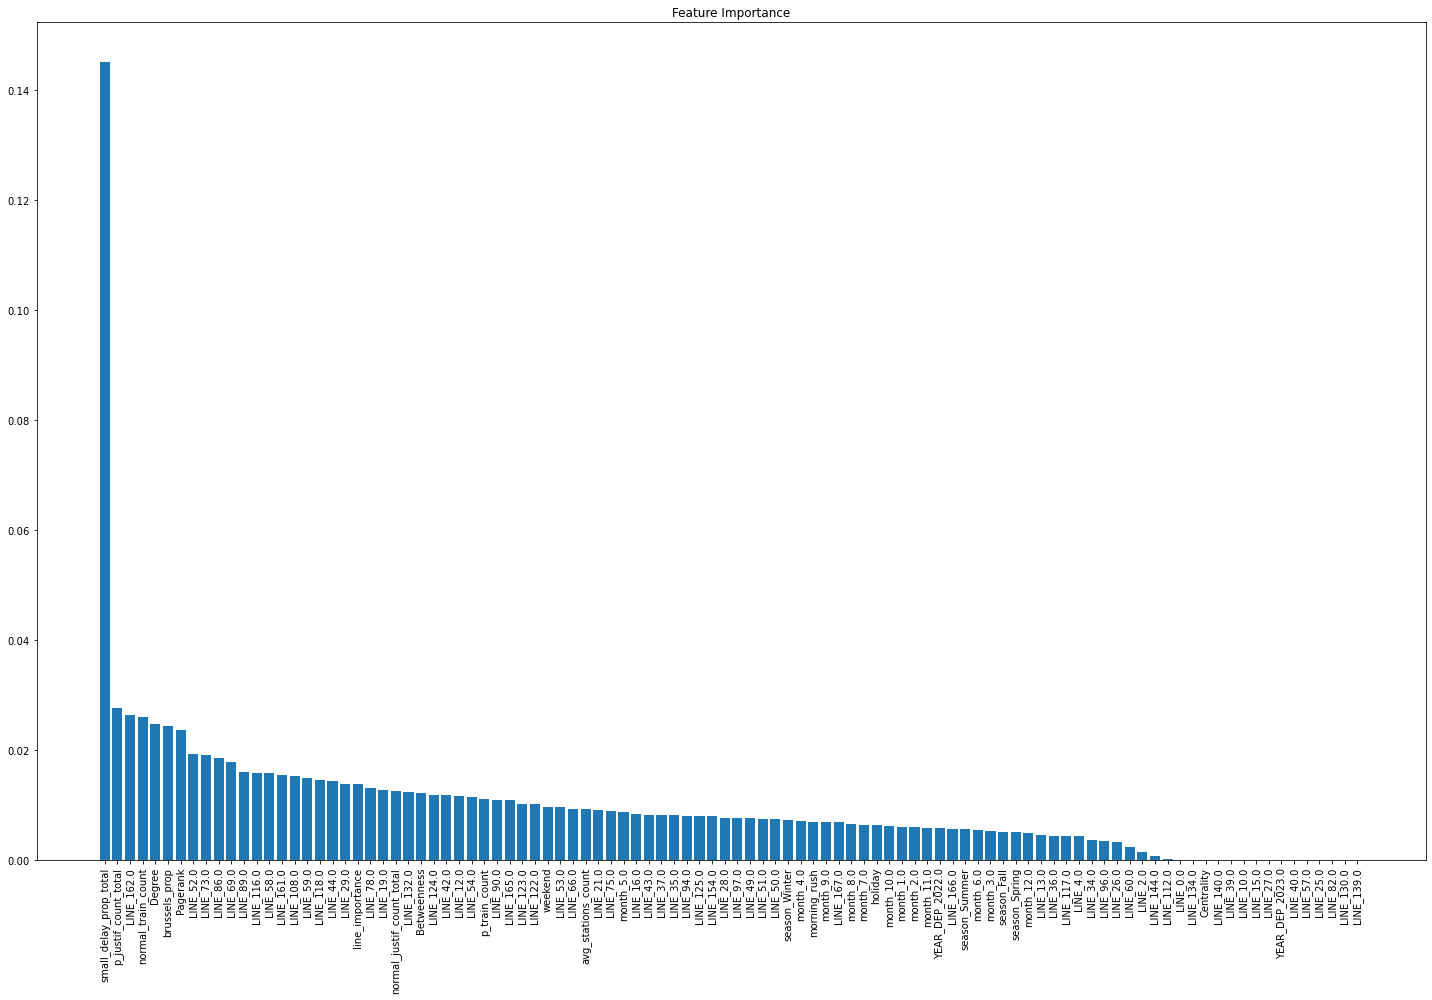

In [16]:
# Feature importances:

importances = xgbc.feature_importances_

sorted_indices = np.argsort(importances)[::-1]
 
fig, ax = plt.subplots(figsize=(20, 14)) 
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [17]:
# Predict the labels of the testing data
y_pred = xgbc.predict(X_test)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)



Accuracy: 0.81103983527362
Precision: 0.7991764333227748
Recall: 0.8186242699545749
F1 score: 0.8087834588876422


In [18]:
# Predict the class probabilities for the testing data
y_pred_proba = xgbc.predict_proba(X_test)[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

print('AUC score:', auc_score)

AUC score: 0.8935255851132031


In [19]:
print('Accuracy:', round(accuracy, 2))
print('Precision:', round(precision, 2))
print('Recall:', round(recall, 2))
print('F1 score:', round(f1, 2))
print(' - - - ')
print('AUC score:', round(auc_score, 2))

Accuracy: 0.81
Precision: 0.8
Recall: 0.82
F1 score: 0.81
 - - - 
AUC score: 0.89


In [20]:
# Create an explainer object for the random forest classifier
explainer = shap.TreeExplainer(xgbc)

# Calculate the SHAP values for a single instance
shap_values = explainer.shap_values(X_test)

# Print the SHAP values and corresponding feature names
print('SHAP values:', shap_values)
print('Feature names:', X_test.columns)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


SHAP values: [[ 0.0355751   0.00119218 -0.03779016 ...  0.00679837 -0.00227853
  -0.00214593]
 [ 0.05628667  0.00396834 -0.06495529 ...  0.01439104  0.05775488
  -0.00017891]
 [ 0.01182508  0.0017255  -0.11306327 ...  0.00267928 -0.00450973
  -0.00042422]
 ...
 [-0.00321379  0.00284017 -0.04426804 ...  0.00888874 -0.00211097
   0.00454437]
 [-0.00680477 -0.07231887 -0.06977369 ...  0.0118131  -0.00261977
  -0.00014674]
 [-0.00743355  0.00157337 -0.06263664 ...  0.00321205 -0.00468809
  -0.00027684]]
Feature names: Index(['weekend', 'holiday', 'p_train_count', 'brussels_prop',
       'avg_stations_count', 'p_justif_count_total',
       'normal_justif_count_total', 'normal_train_count',
       'small_delay_prop_total', 'line_importance', 'morning_rush', 'Degree',
       'Betweenness', 'Centrality', 'Pagerank', 'LINE_0.0', 'LINE_10.0',
       'LINE_108.0', 'LINE_112.0', 'LINE_116.0', 'LINE_117.0', 'LINE_118.0',
       'LINE_12.0', 'LINE_122.0', 'LINE_123.0', 'LINE_124.0', 'LINE_125.0',
  

In [28]:

# example array of predicted probabilities
# find the indexes of the ten highest and lowest values
top_indexes = y_pred_proba.argsort()[-10:][::-1]
bottom_indexes = y_pred_proba.argsort()[:10]

print("Indexes of top 10 values:", top_indexes)
print("Indexes of bottom 10 values:", bottom_indexes)

Indexes of top 10 values: [  675  5855  7794  6864 12275  9748 10864  6624 11681 11398]
Indexes of bottom 10 values: [ 6877  2986  3538 10892   682  9009  9287  4992 10680  4645]


In [29]:
print(y_test[top_indexes[0]])
shap.force_plot(explainer.expected_value, shap_values[top_indexes[0],:], X_test.iloc[top_indexes[0],:], link="logit")

1


In [30]:
print(y_test[bottom_indexes[0]])
shap.force_plot(explainer.expected_value, shap_values[bottom_indexes[0],:], X_test.iloc[bottom_indexes[0],:], link="logit")

0


In [31]:
print(y_test[24])
shap.force_plot(explainer.expected_value, shap_values[24,:], X_test.iloc[24,:], link="logit")

1


In [32]:
print(y_test[2])
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test.iloc[2,:], link="logit")


1


In [34]:
print(y_test[10])
shap.force_plot(explainer.expected_value, shap_values[10,:], X_test.iloc[10,:], link="logit")

1


In [35]:
print(y_test[9])
shap.force_plot(explainer.expected_value, shap_values[9,:], X_test.iloc[9,:], link="logit")

0


In [37]:
print(y_test[15])
shap.force_plot(explainer.expected_value, shap_values[15,:], X_test.iloc[15,:], link="logit")

0


In [36]:
print(y_test[12619])
shap.force_plot(explainer.expected_value, shap_values[12619,:], X_test.iloc[12619,:], link="logit")

1


In [33]:
df_pred_real = pd.DataFrame({'real': y_test, 'pred' :y_pred_proba})
df_pred_real['pred_bin'] = df_pred_real['pred'].apply(lambda x: 1 if x > .5 else 0)
df_pred_real

# use boolean indexing to get the row indexes where the value in "real" is not equal to the value in "pred_bin"
result = df_pred_real.loc[df_pred_real['real'] != df_pred_real['pred_bin']].index
print(result)

df_pred_real.iloc[result, :]

Index([    9,    10,    11,    16,    19,    20,    37,    40,    41,    49,
       ...
       12596, 12598, 12602, 12605, 12613, 12615, 12617, 12619, 12622, 12625],
      dtype='int64', length=2386)


real      pred  pred_bin
9         0  0.601283         1
10        1  0.300821         0
11        1  0.318268         0
16        1  0.235048         0
19        0  0.853576         1
...     ...       ...       ...
12615     1  0.077124         0
12617     0  0.724727         1
12619     1  0.484135         0
12622     1  0.494232         0
12625     1  0.361537         0

[2386 rows x 3 columns]

[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81]
Index(['LINE_0.0', 'LINE_10.0', 'LINE_108.0', 'LINE_112.0', 'LINE_116.0',
       'LINE_117.0', 'LINE_118.0', 'LINE_12.0', 'LINE_122.0', 'LINE_123.0',
       'LINE_124.0', 'LINE_125.0', 'LINE_13.0', 'LINE_130.0', 'LINE_132.0',
       'LINE_134.0', 'LINE_139.0', 'LINE_140.0', 'LINE_144.0', 'LINE_15.0',
       'LINE_154.0', 'LINE_16.0', 'LINE_161.0', 'LINE_162.0', 'LINE_165.0',
       'LINE_166.0', 'LINE_167.0', 'LINE_19.0', 'LINE_2.0', 'LINE_21.0',
       'LINE_25.0', 'LINE_26.0', 'LINE_27.0', 'LINE_28.0', 'LINE_29.0',
       'LINE_34.0', 'LINE_35.0', 'LINE_36.0', 'LINE_37.0', 'LINE_39.0',
       'LINE_4.0', 'LINE_40.0', 'LINE_42.0', 'LINE_43.0', 'LINE_44.0',
       'LINE_49.0', 'LINE_50.0', 'LINE_51.0', 'LINE_52.0', 'LINE_

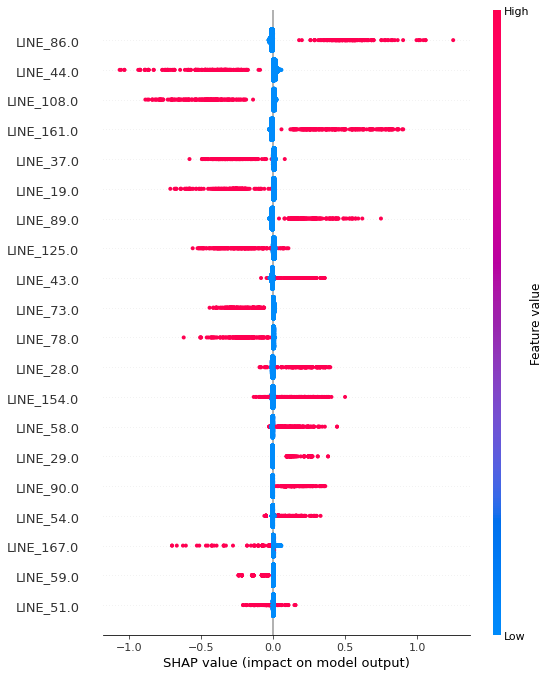

<Figure size 432x288 with 0 Axes>

In [22]:
# Make a list of indices of the line Numbers
list_line_indices = list()
for i, column in enumerate(X_test.columns):
    if f"{column}".startswith("LINE_") == True:
        list_line_indices.append(i)

print(list_line_indices)
print(X_test.columns[list_line_indices])

# make shap plot for line numbers
shap.summary_plot(shap_values[:, list_line_indices], X_test.iloc[:, list_line_indices], max_display=20, class_inds=1)
plt.tight_layout()

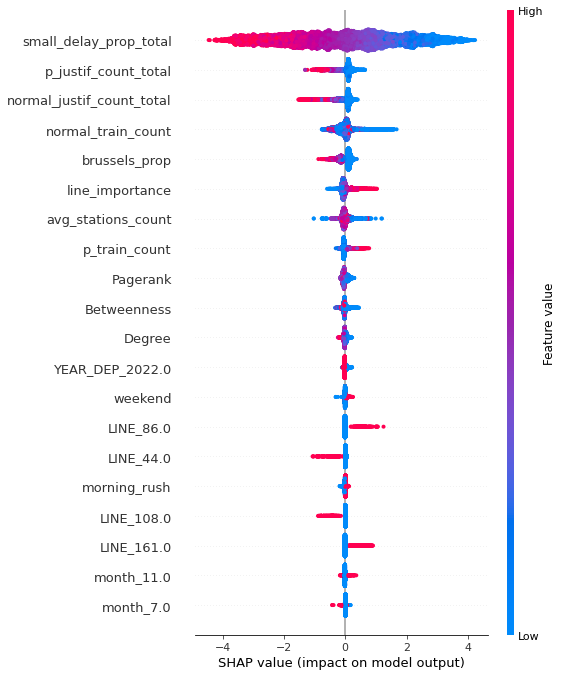

<Figure size 432x288 with 0 Axes>

In [23]:
# get summary plot
shap.summary_plot(shap_values, X_test)
plt.tight_layout()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


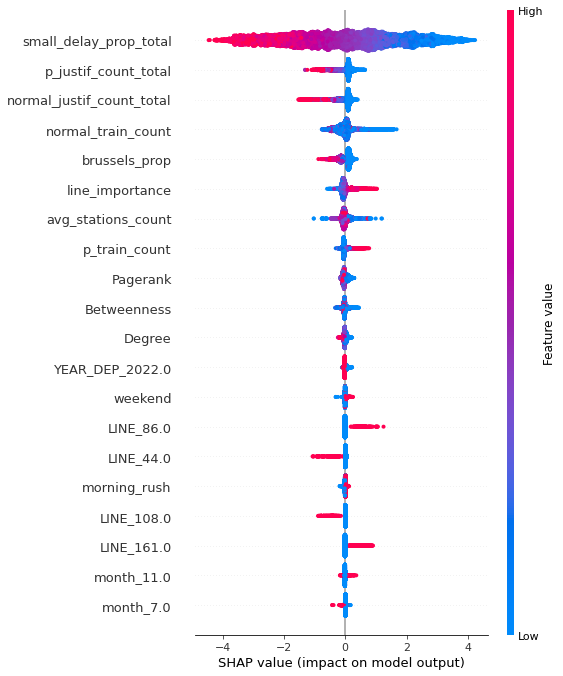

In [24]:
shap_values = explainer.shap_values(X_test)
fig, ax = plt.subplots(figsize=(18, 12))
shap.summary_plot(shap_values, X_test, plot_type='dot', max_display=20)
# show the plot
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


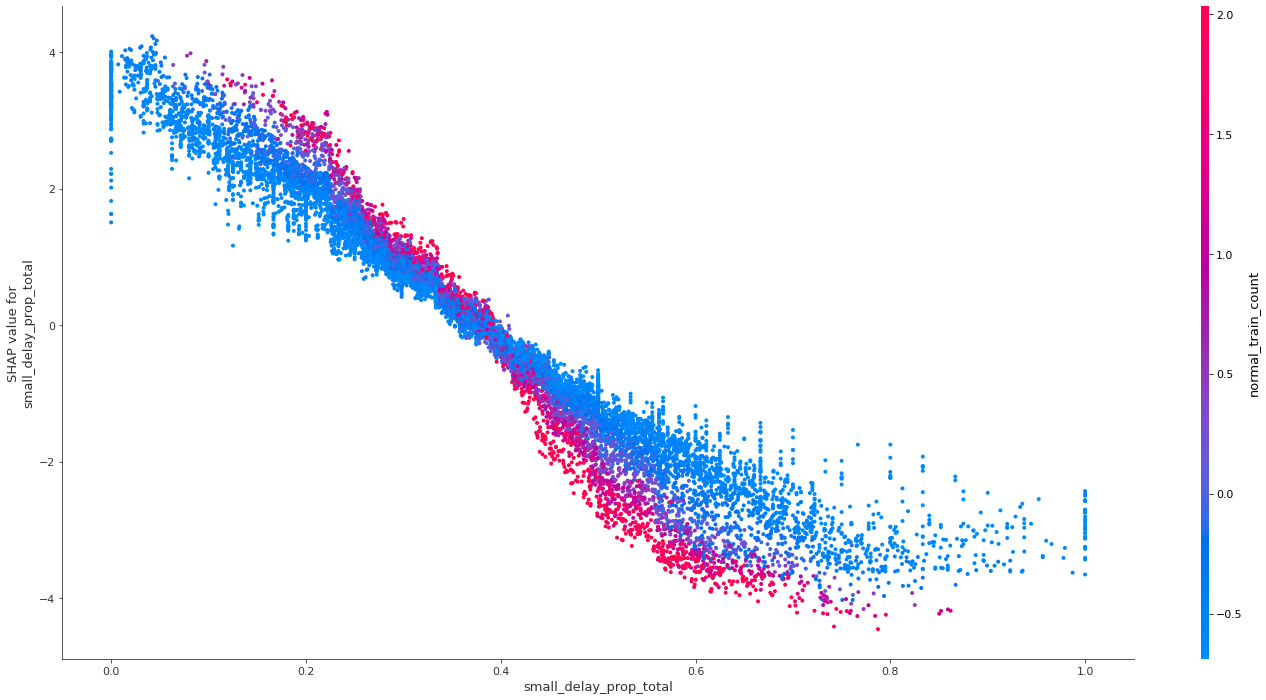

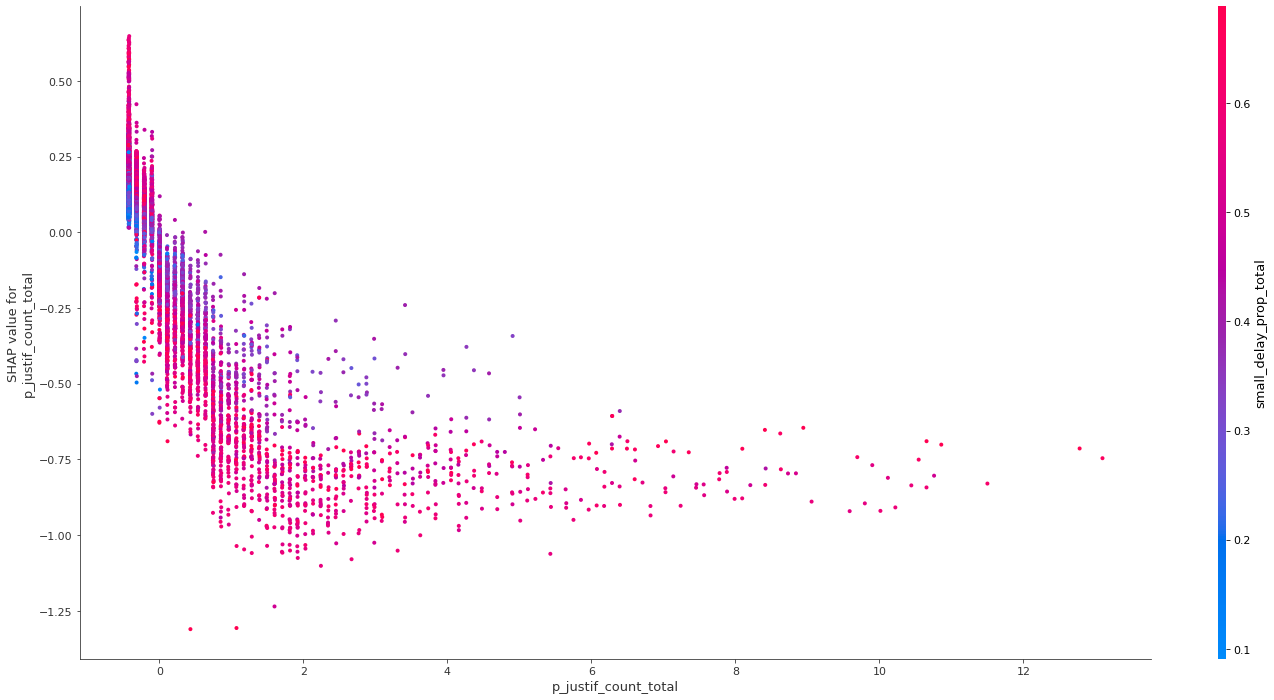

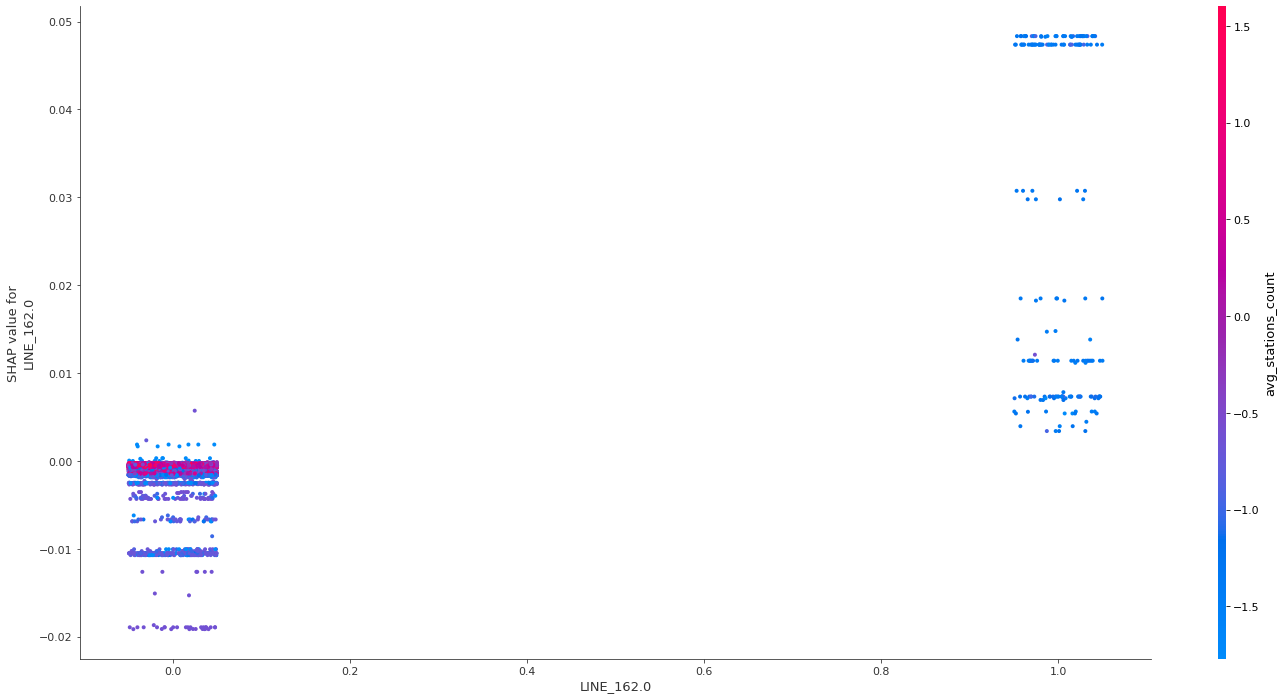

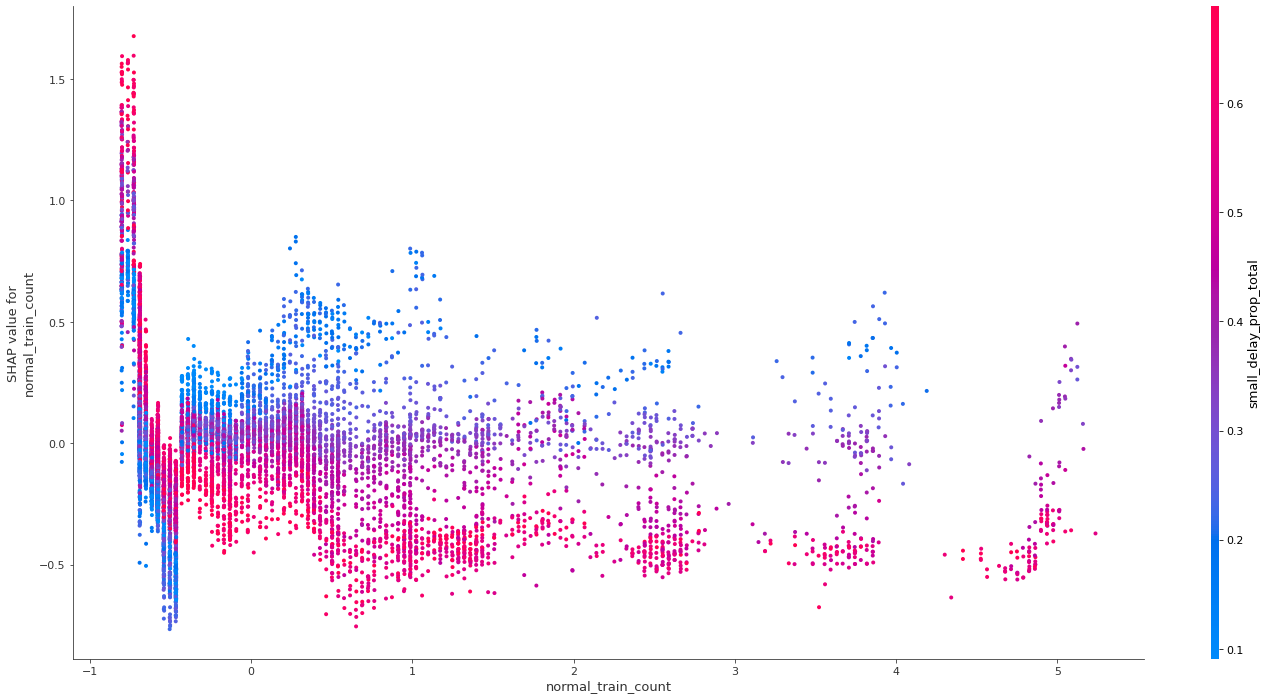

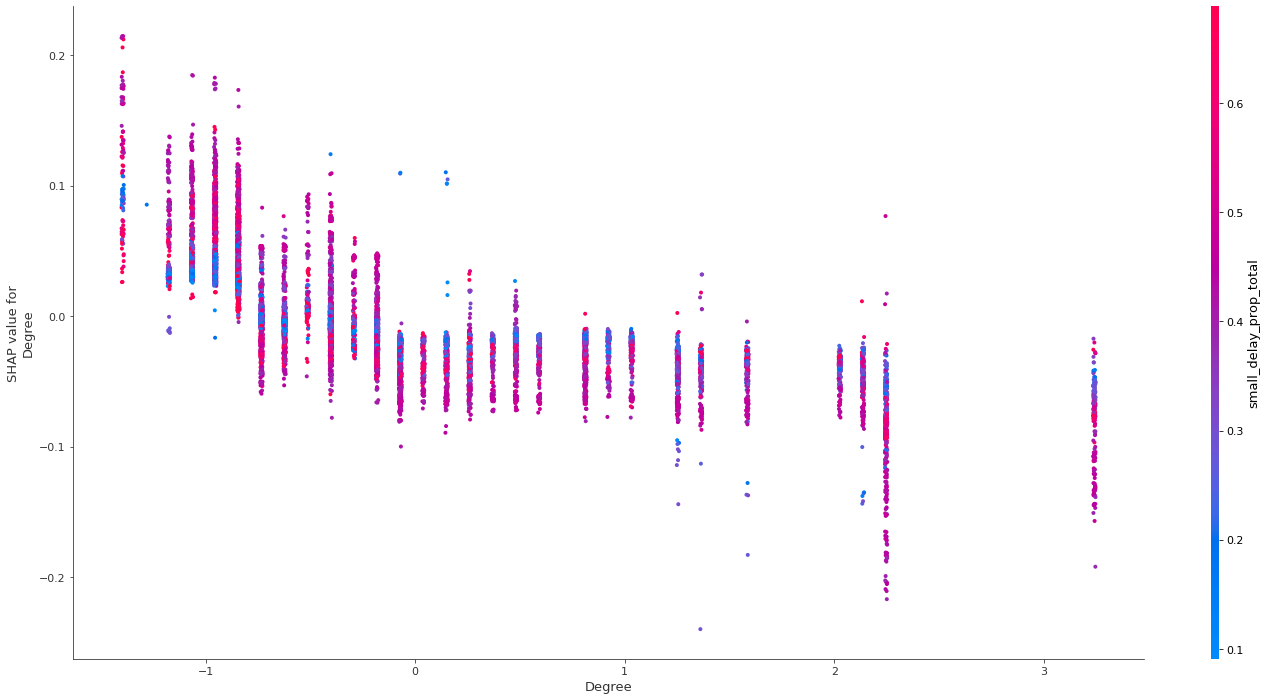

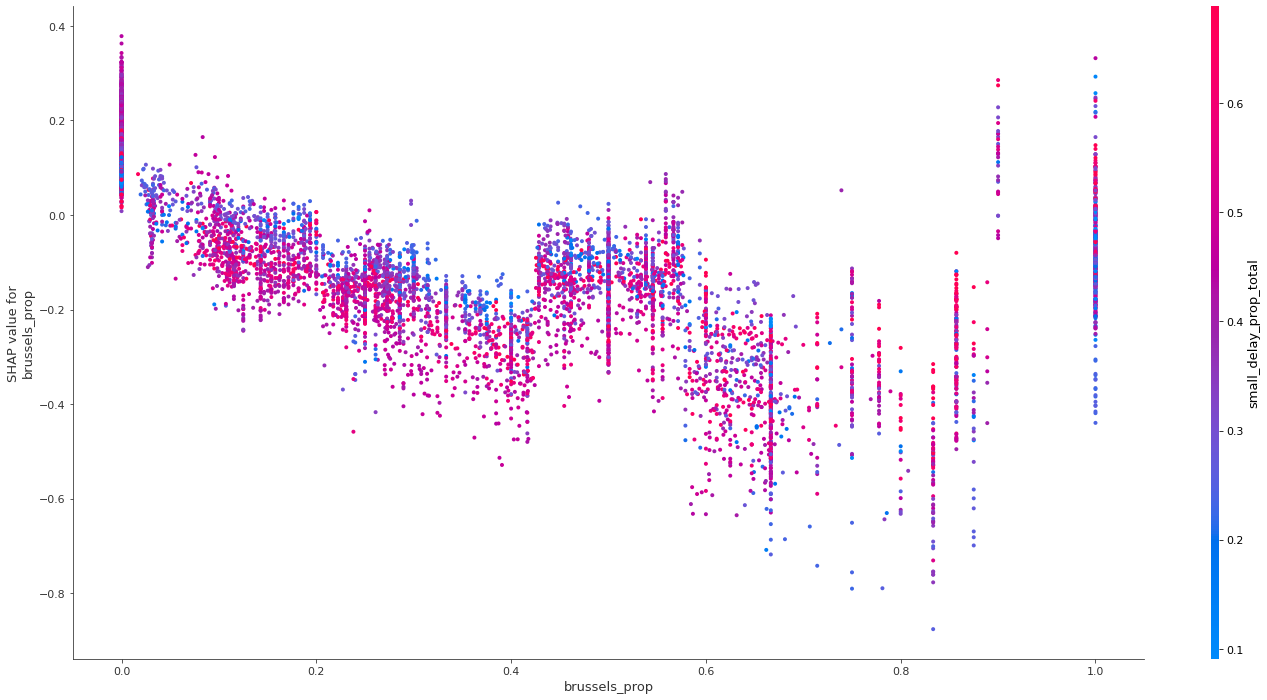

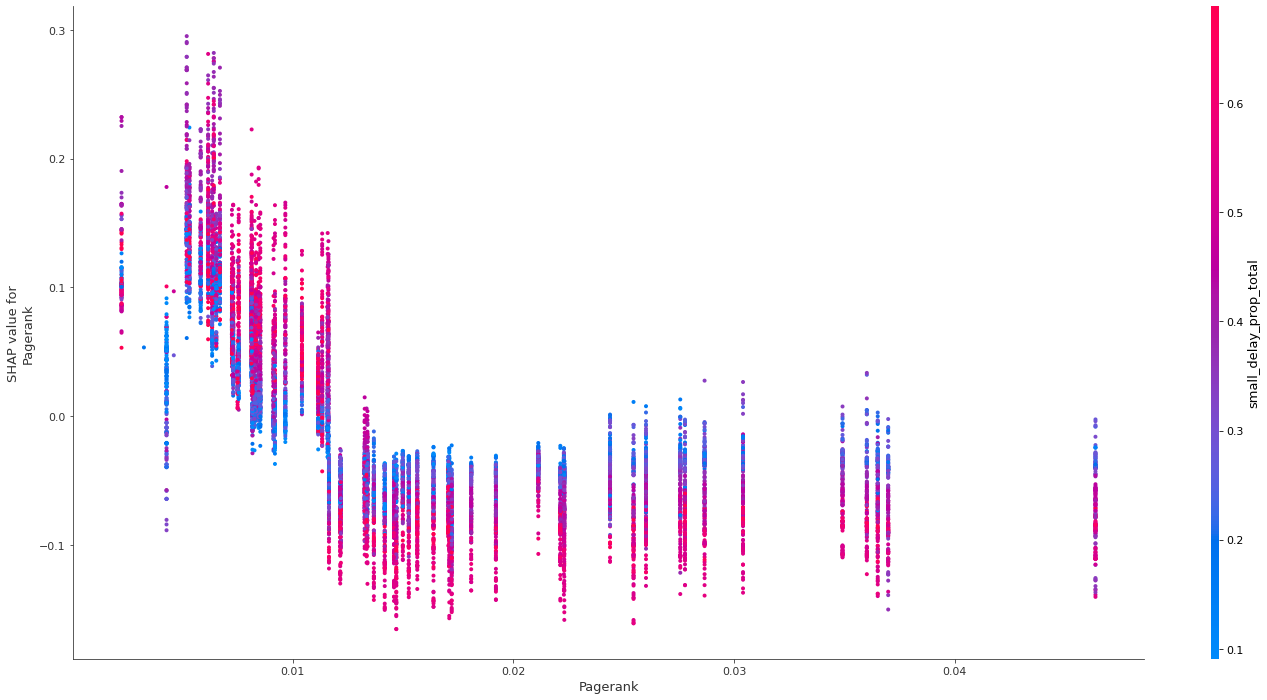

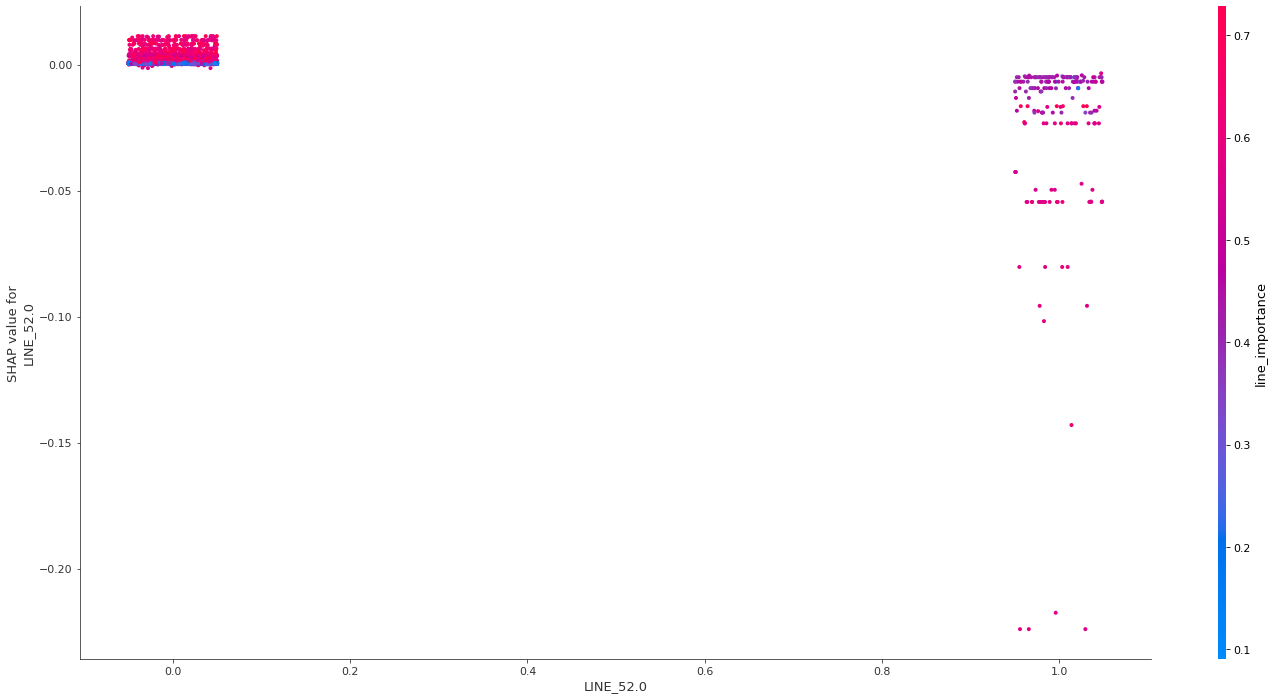

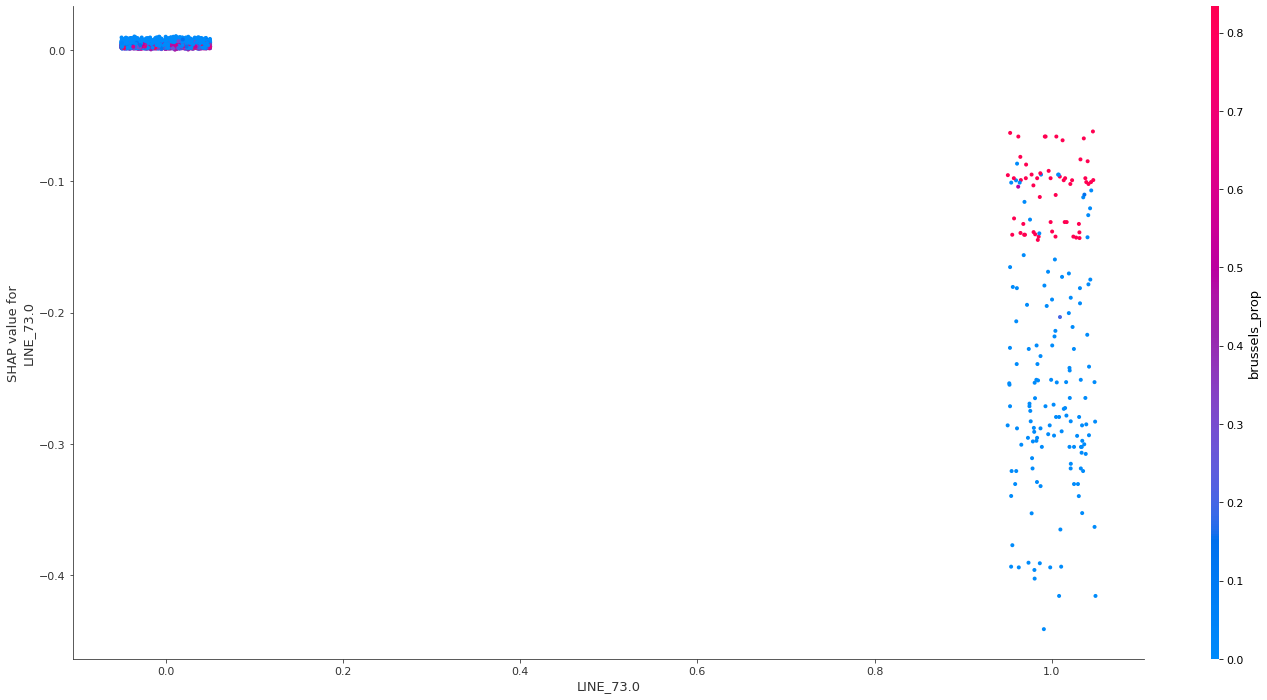

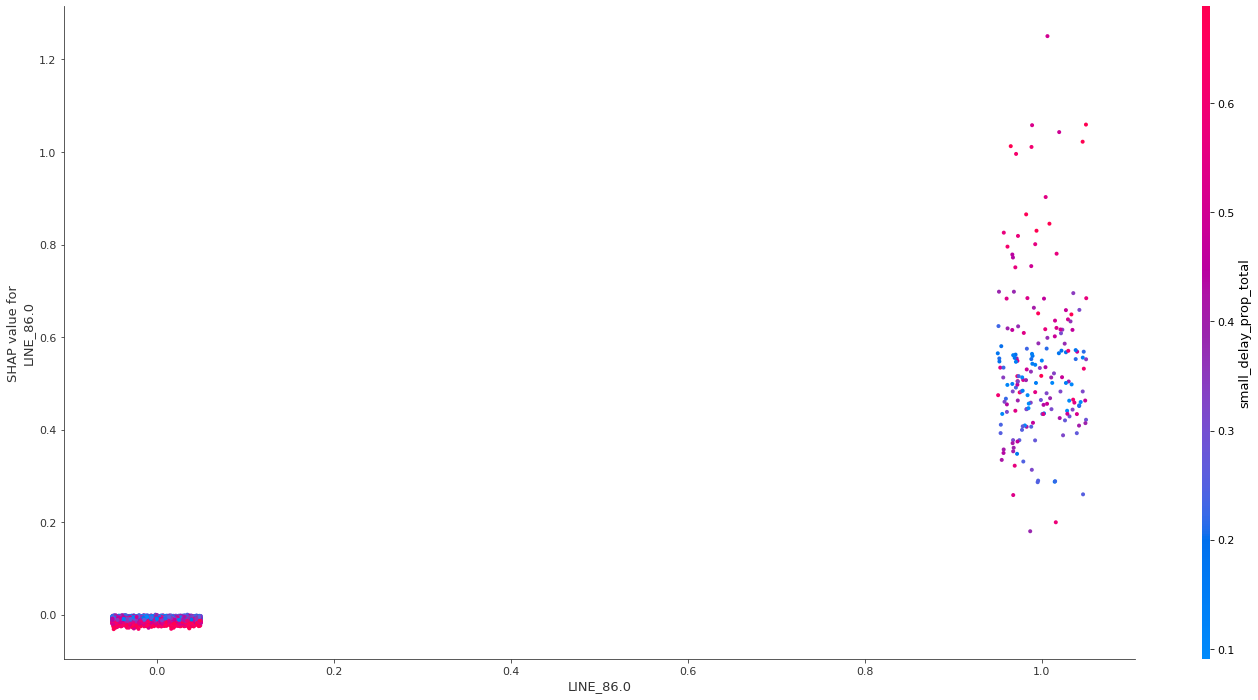

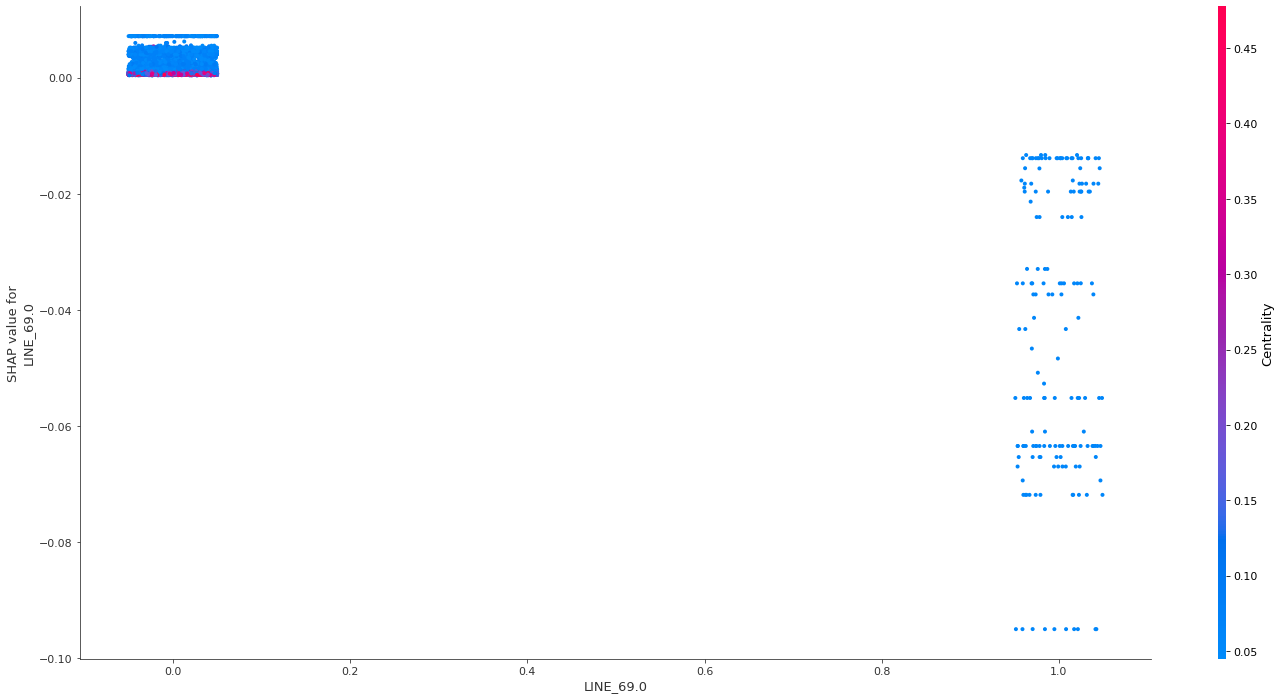

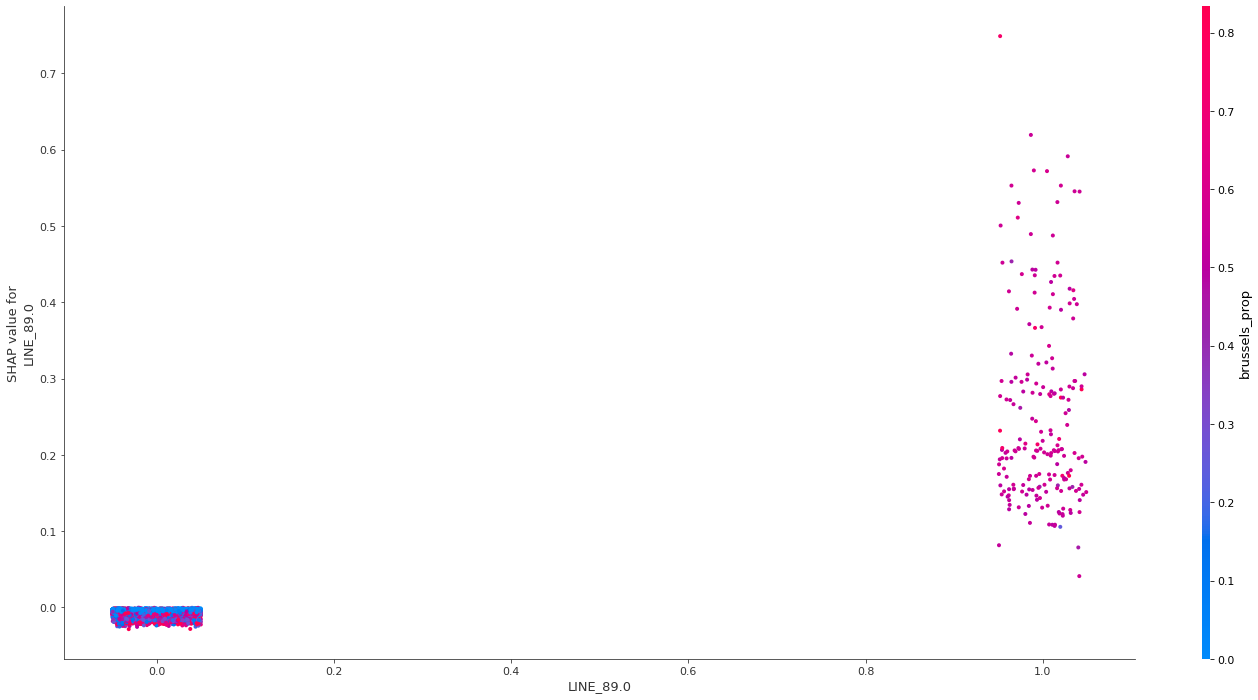

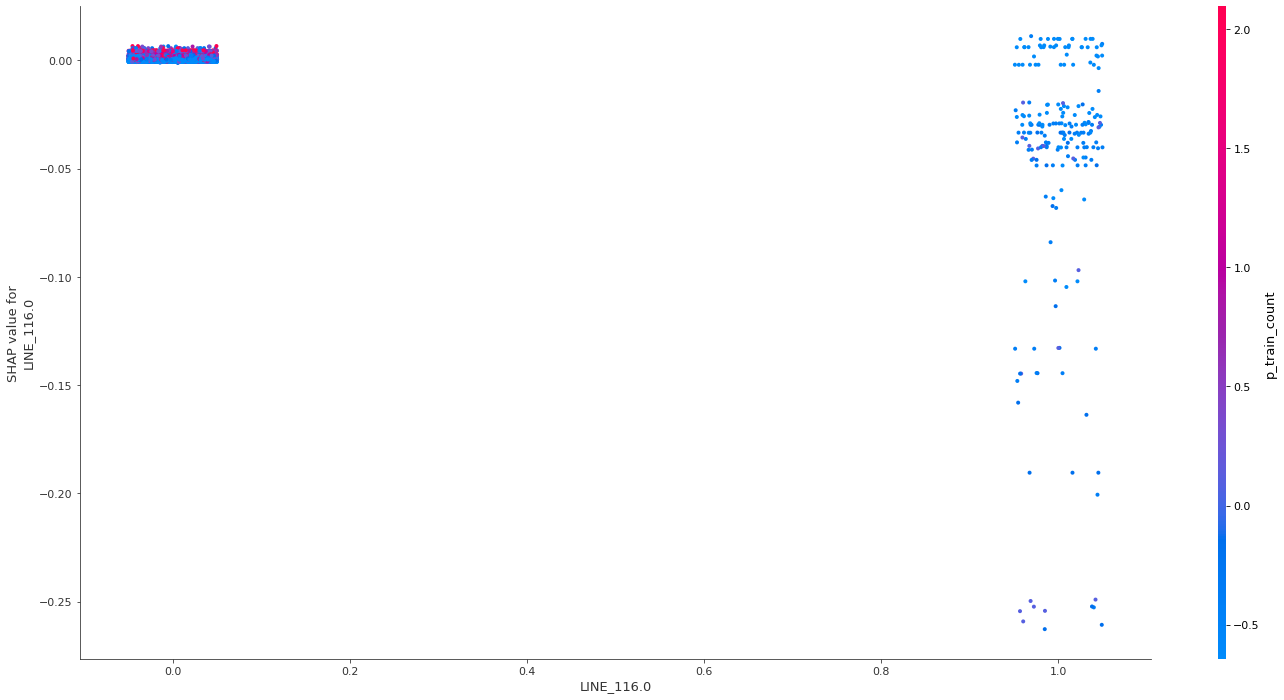

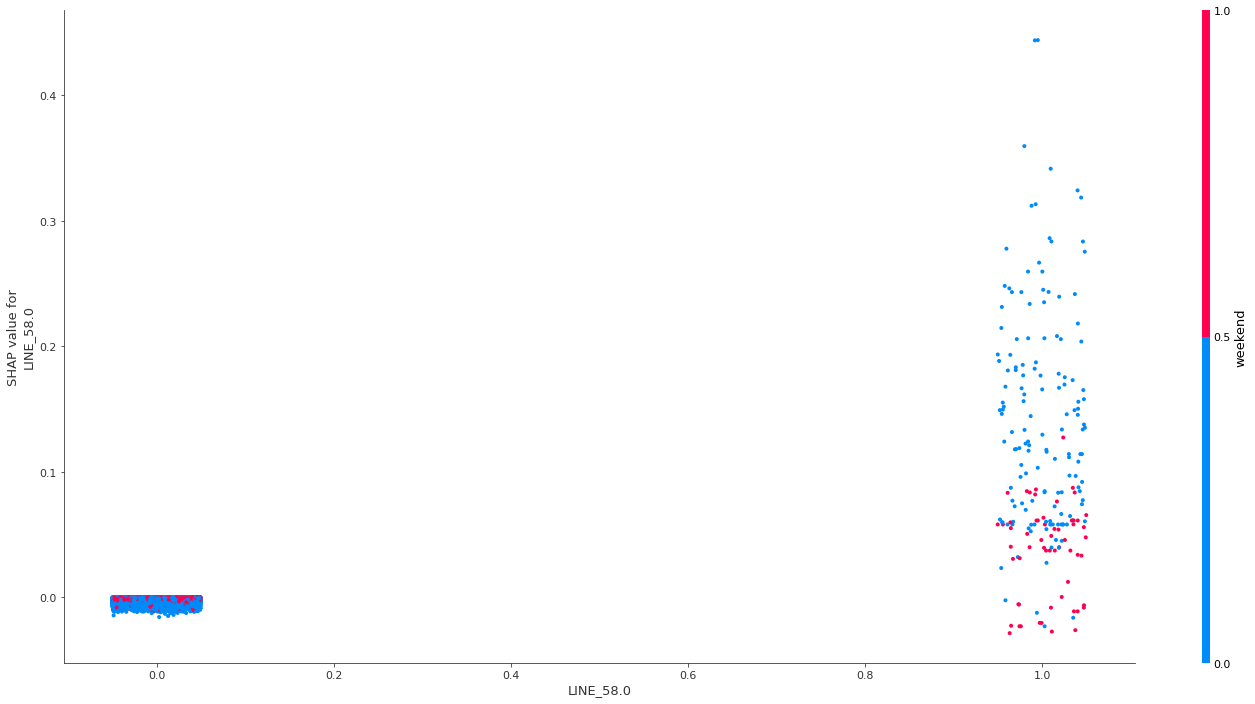

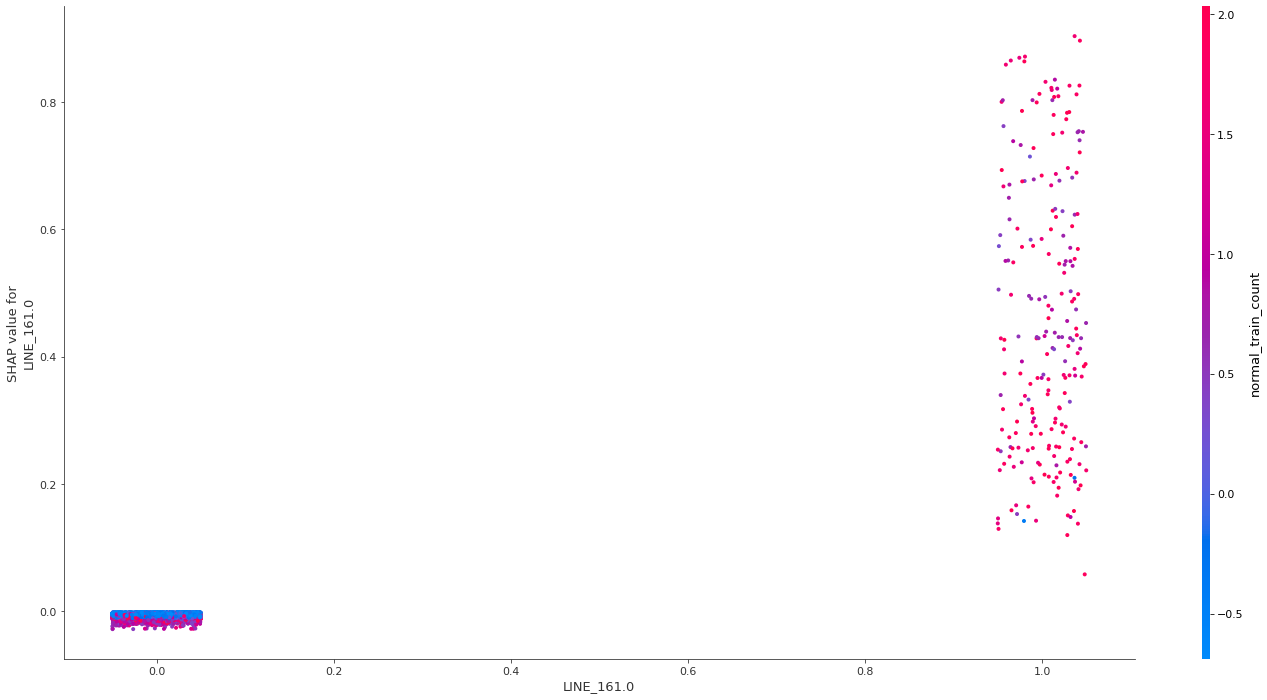

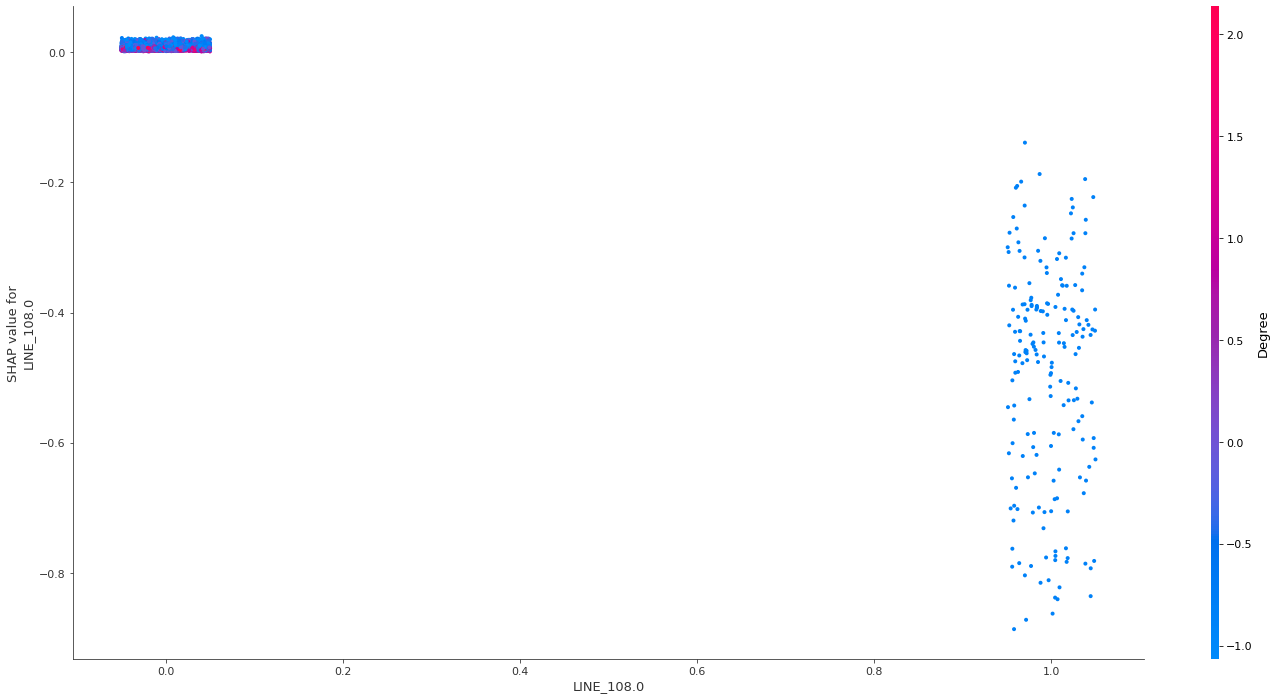

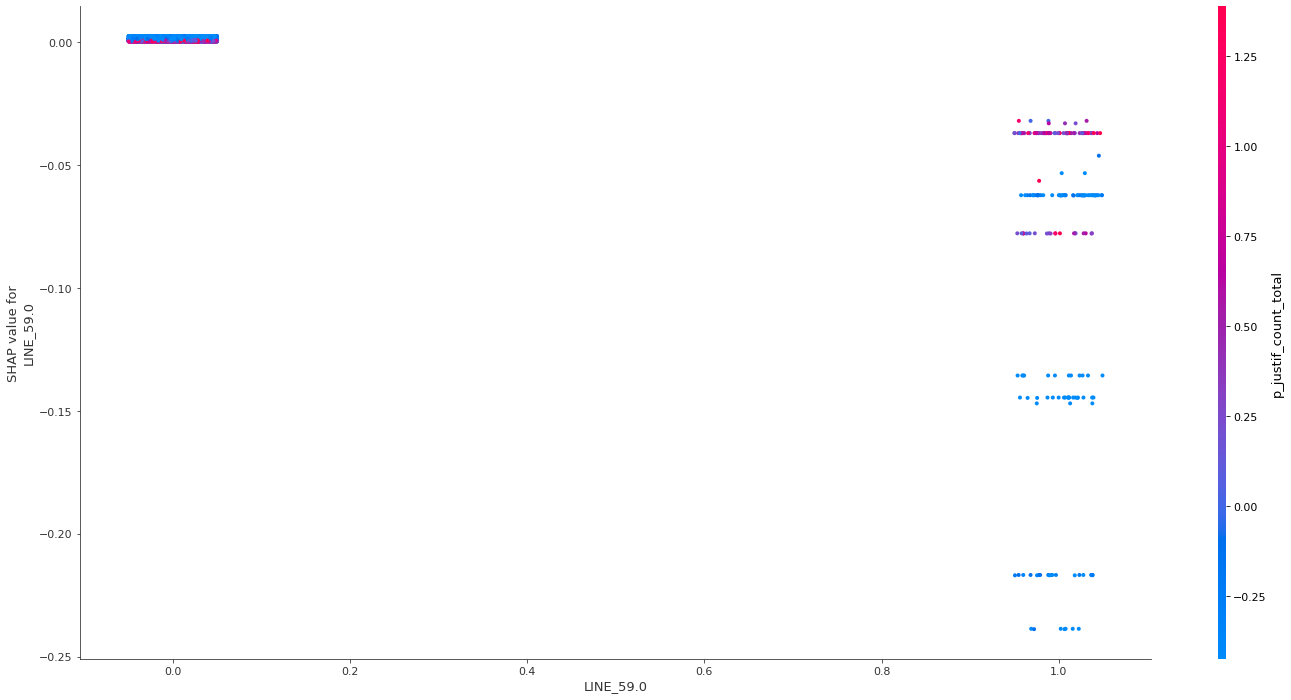

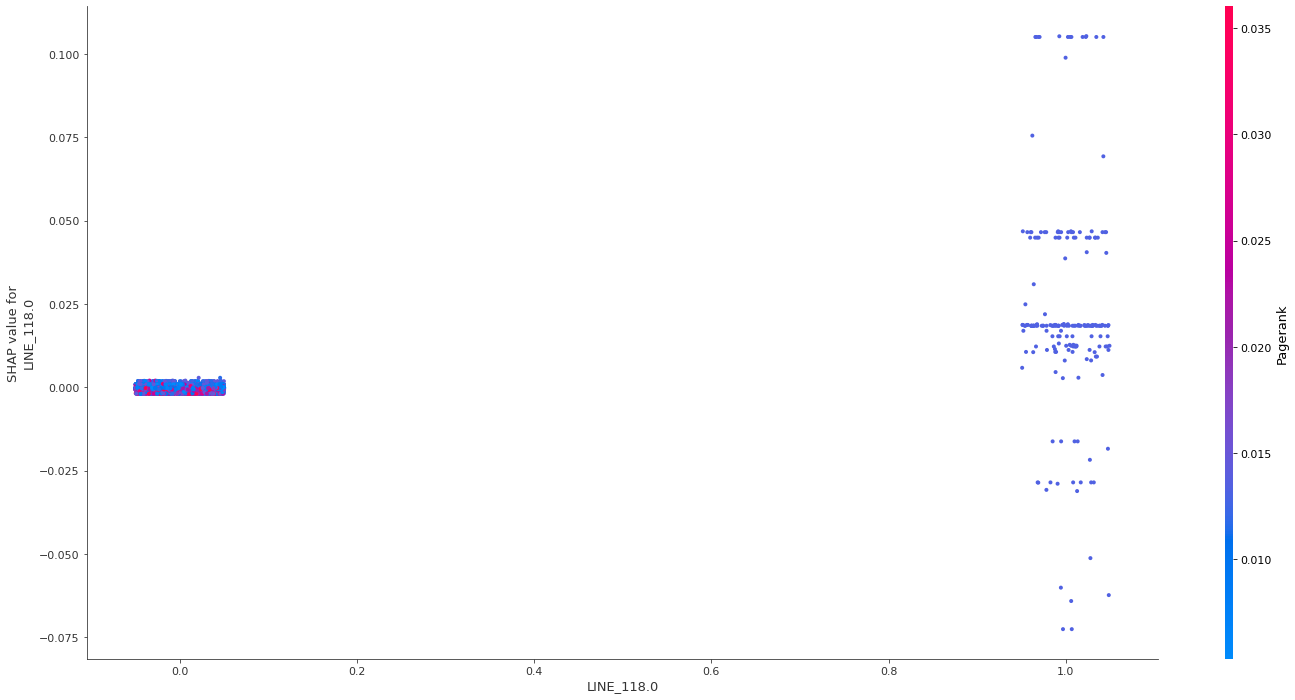

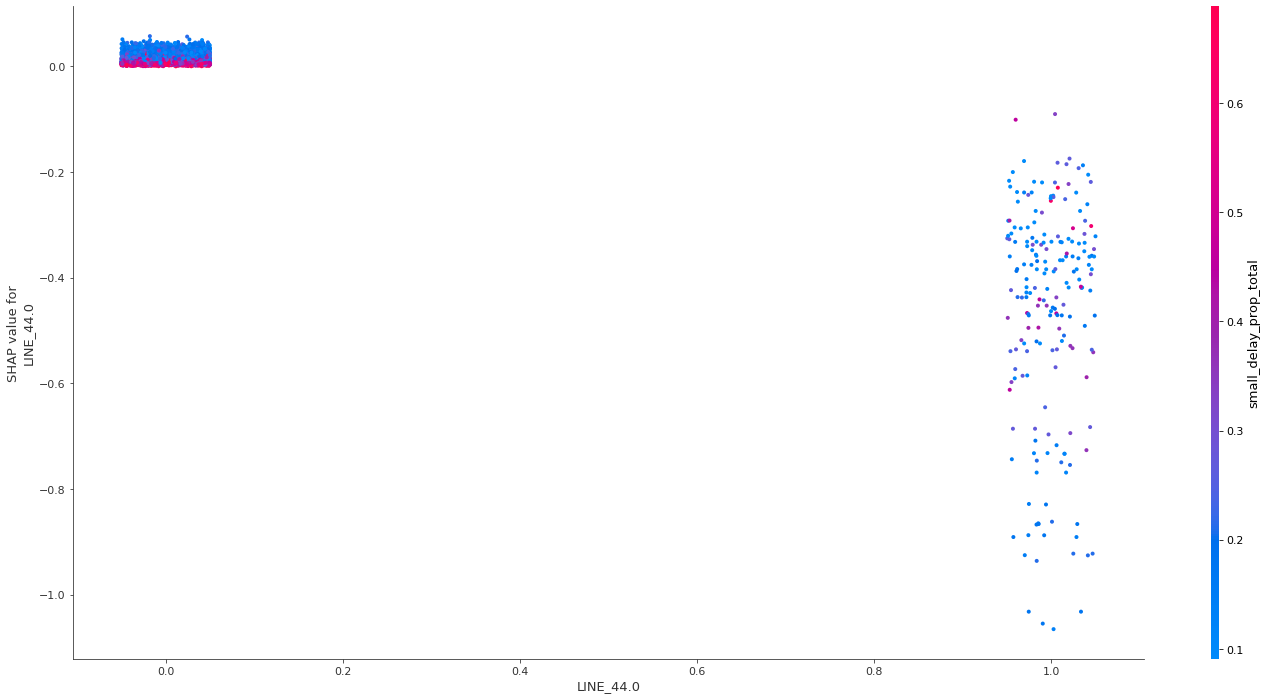

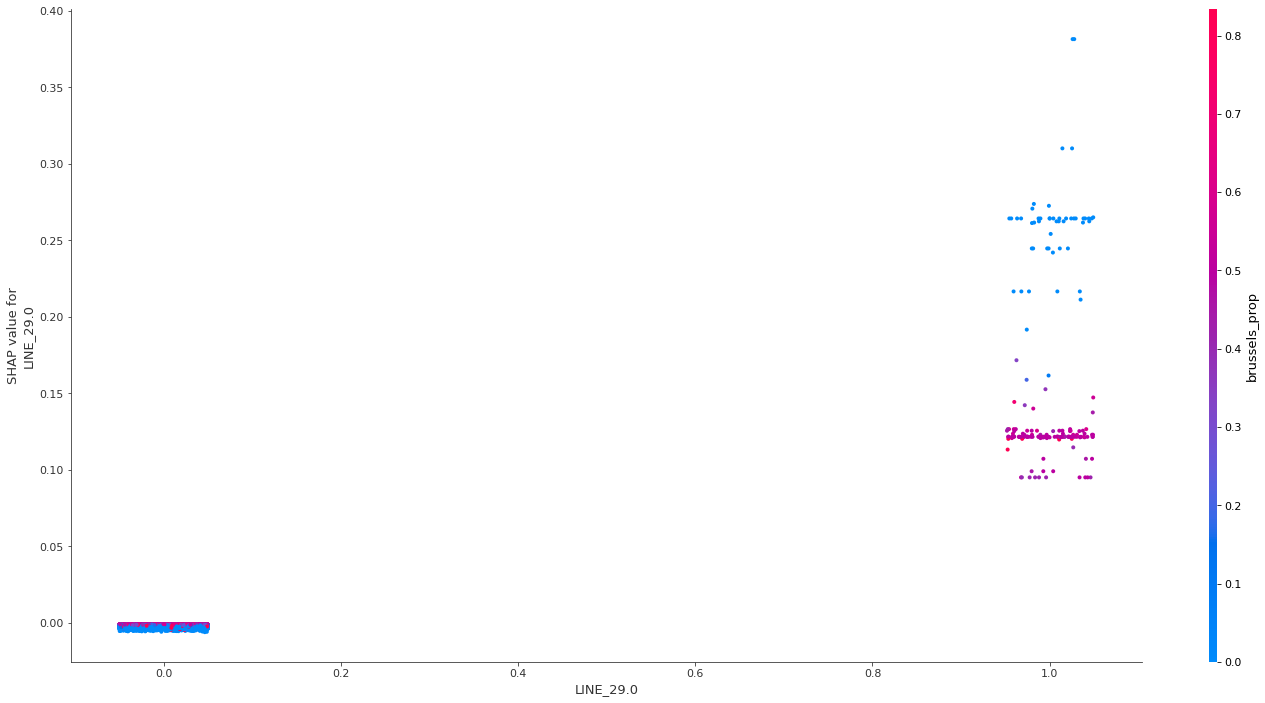

In [25]:
# check shap and interaction effects
shap_values = explainer.shap_values(X_test)
for feat_name in  X_train.columns[sorted_indices][:20]:
    shap.dependence_plot(f"{feat_name}", shap_values, X_test, show = False, x_jitter = .1)

    plt.gcf().set_size_inches(24, 12)
    # Show the plot
    plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


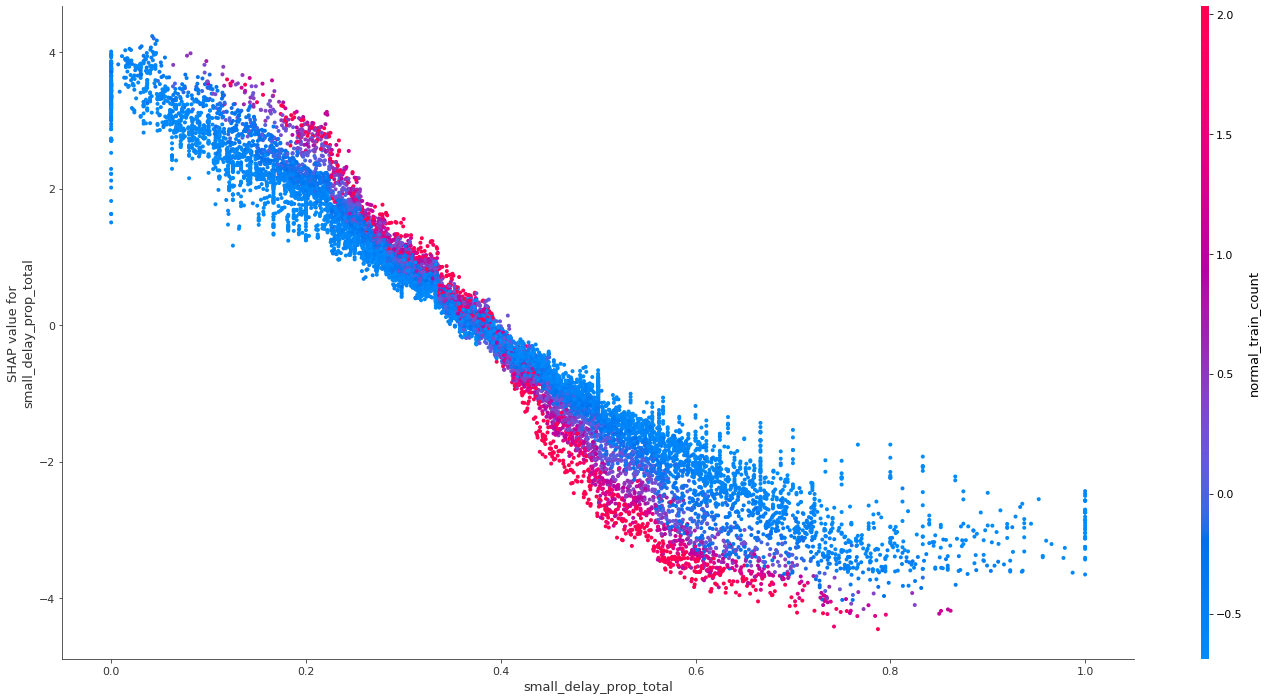

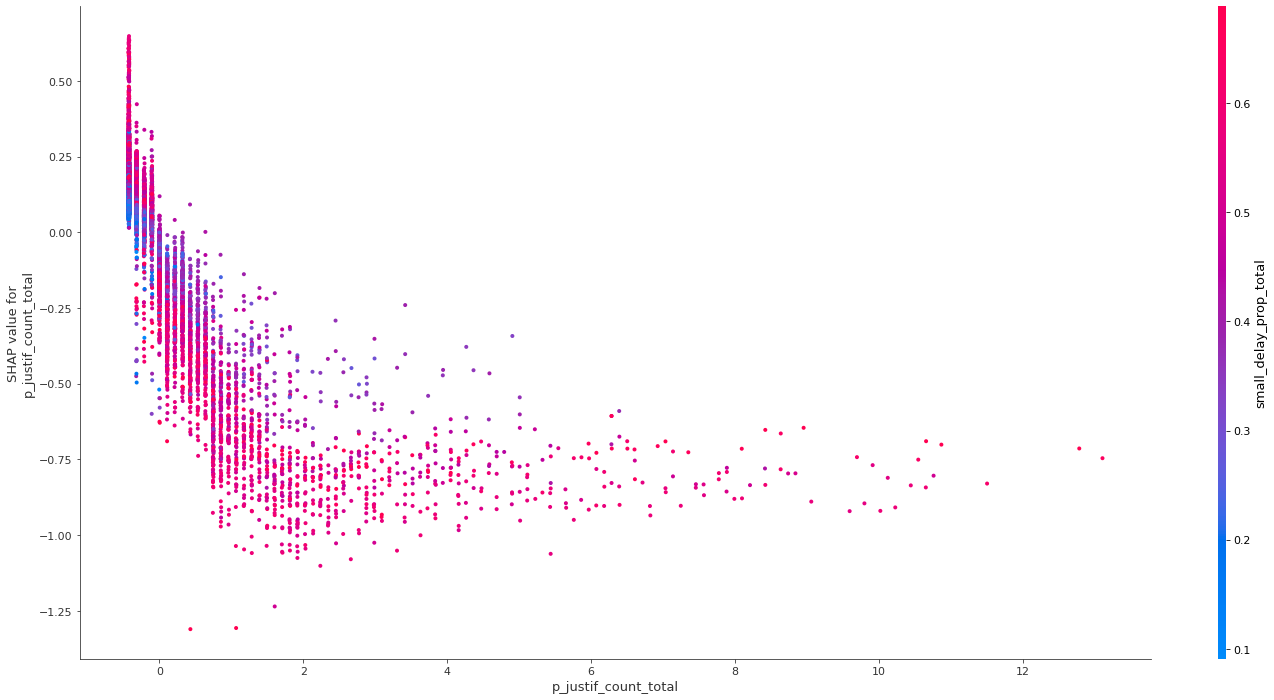

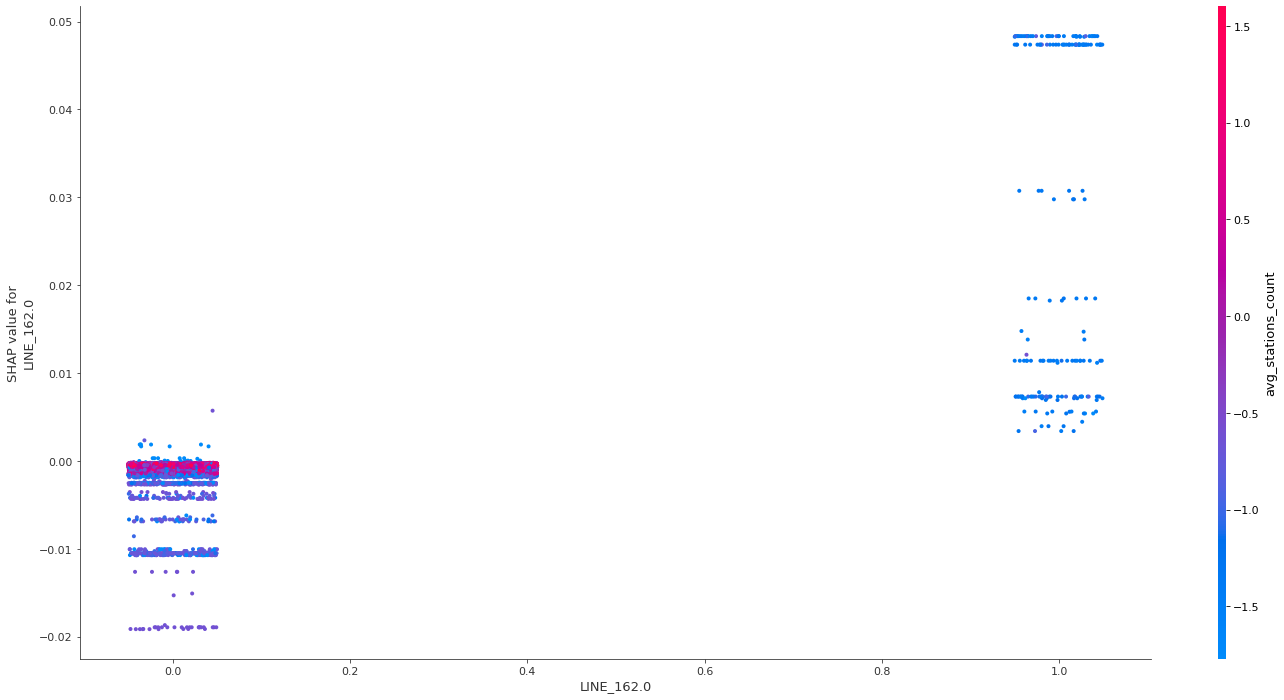

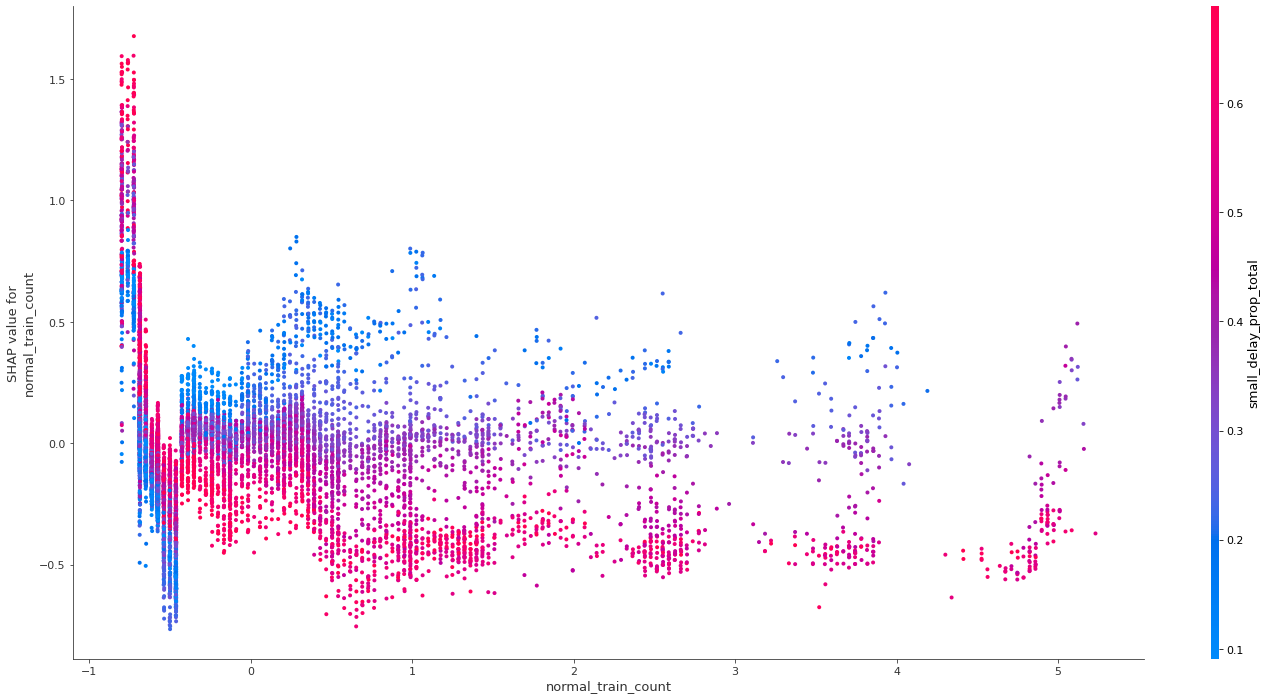

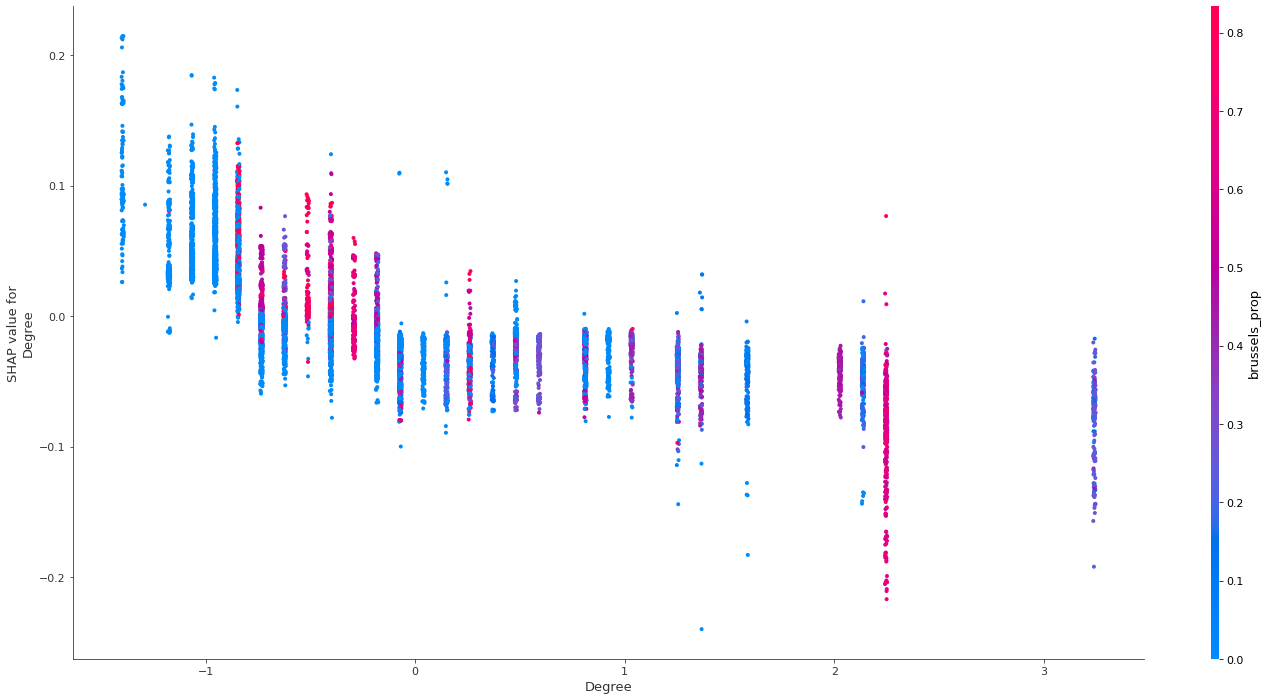

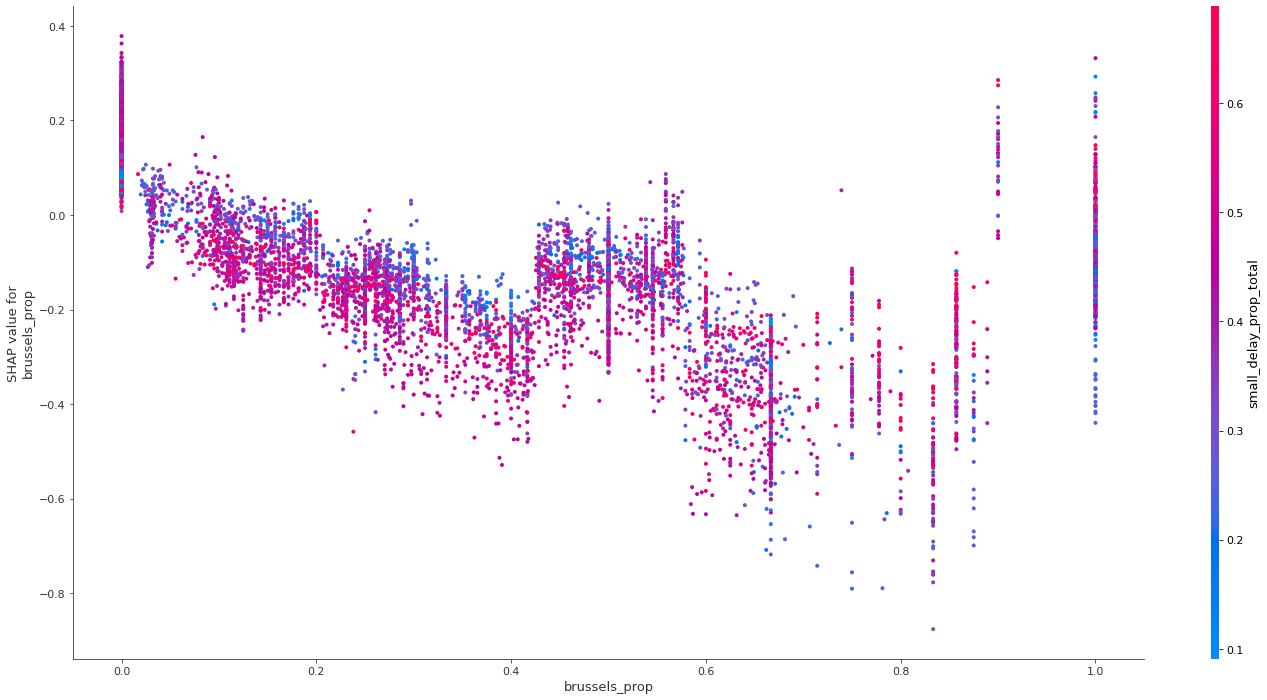

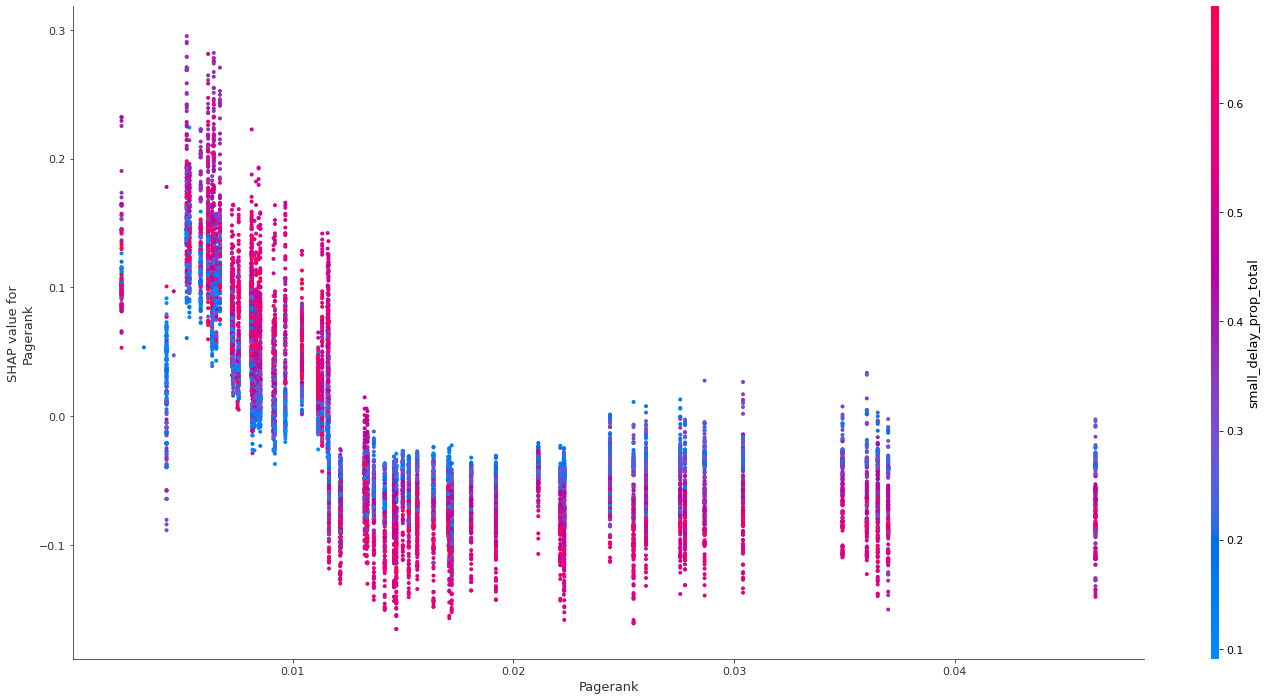

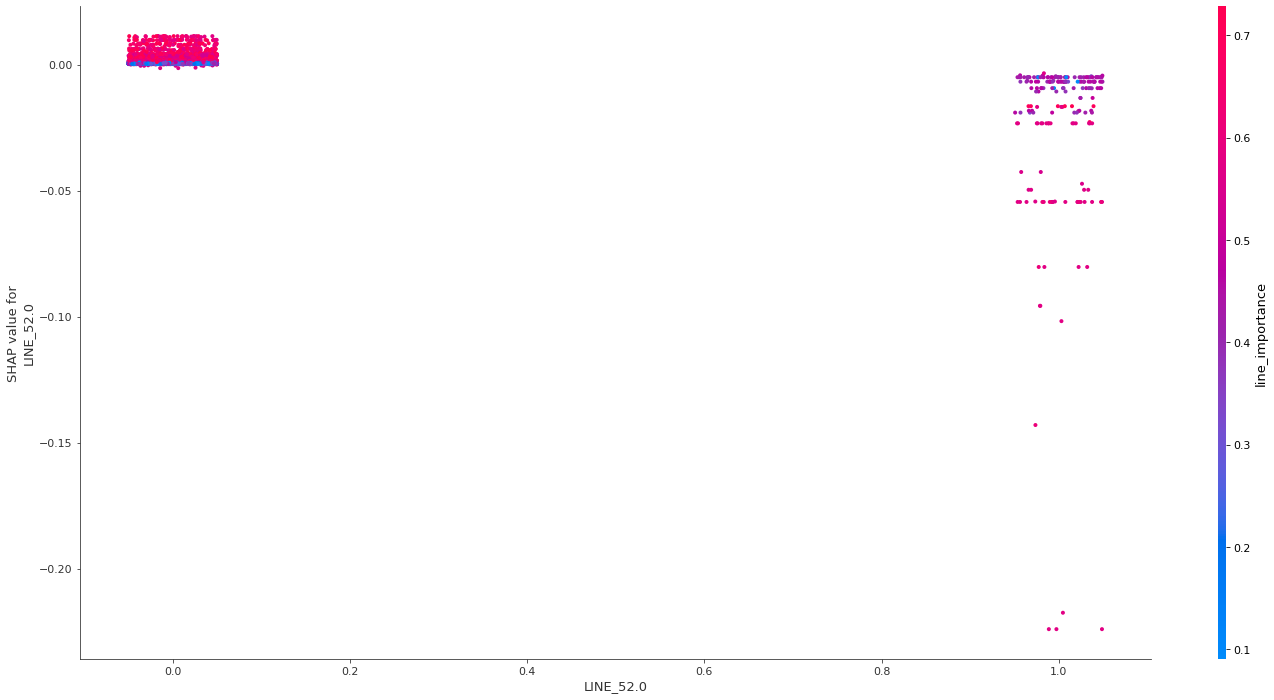

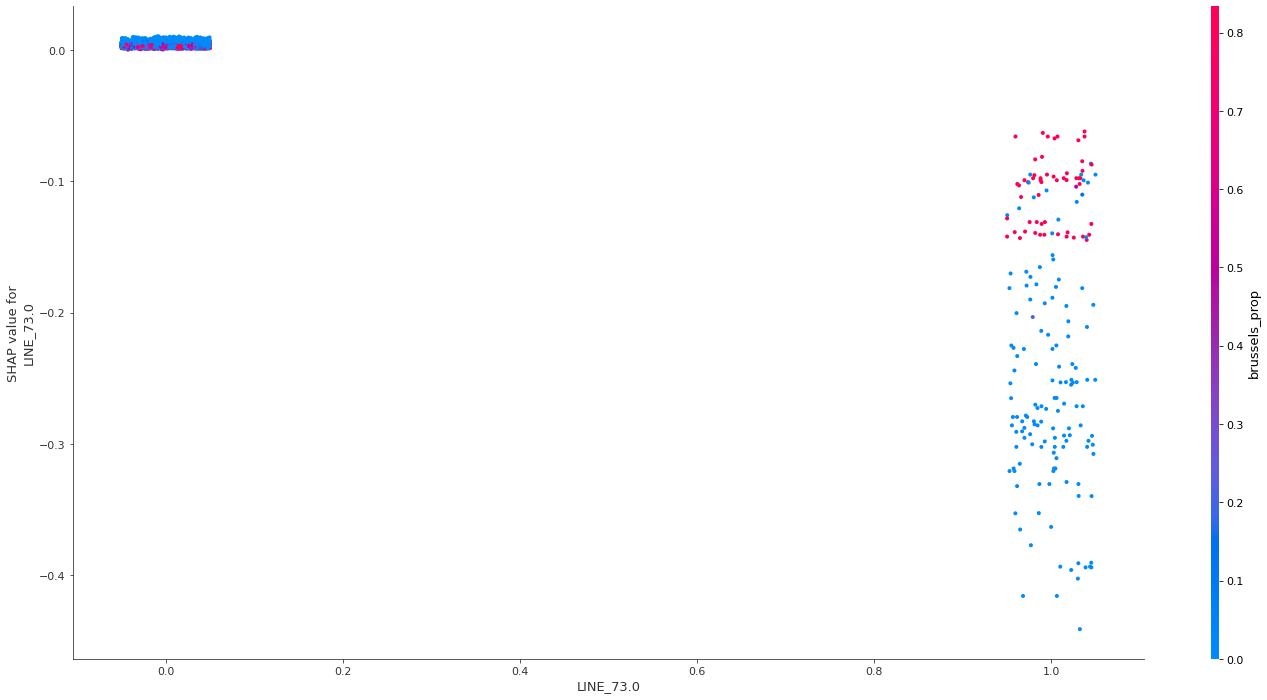

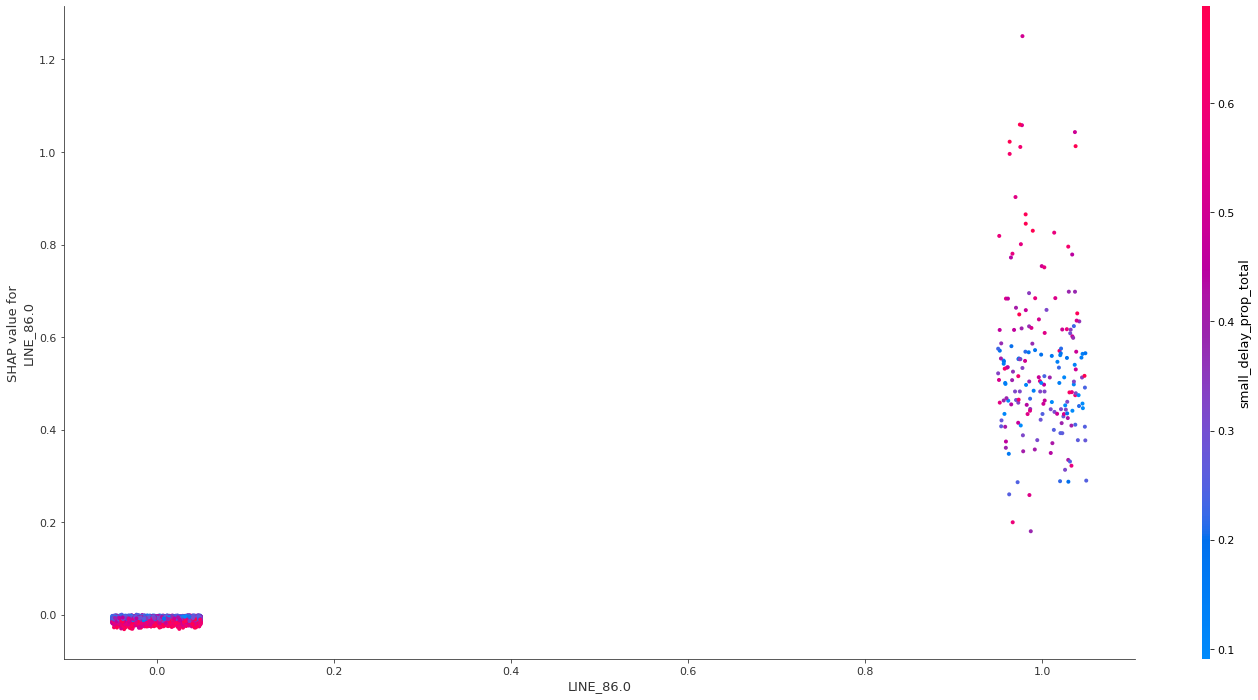

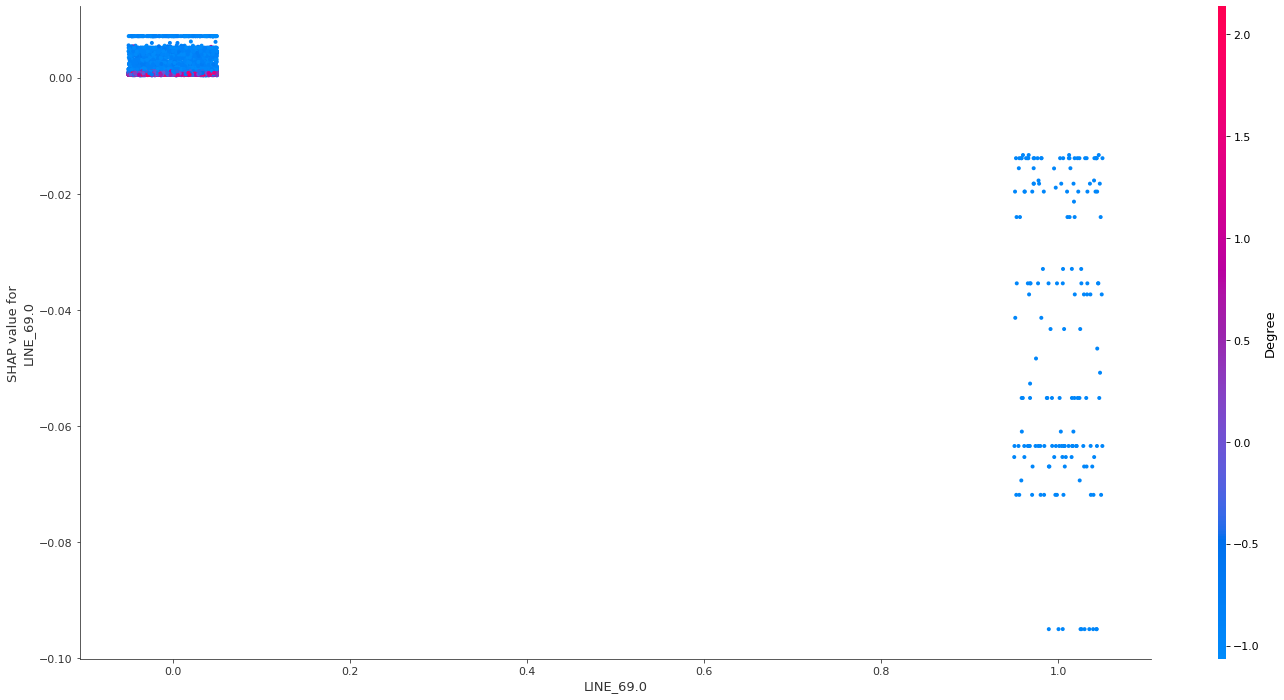

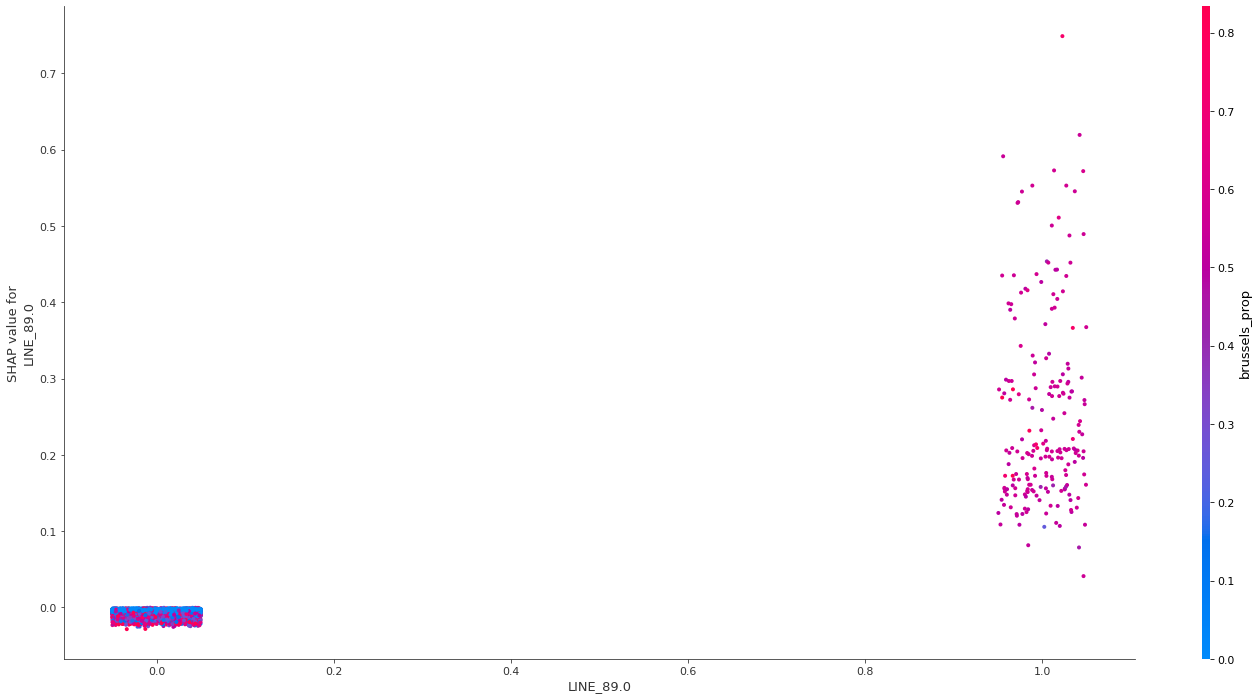

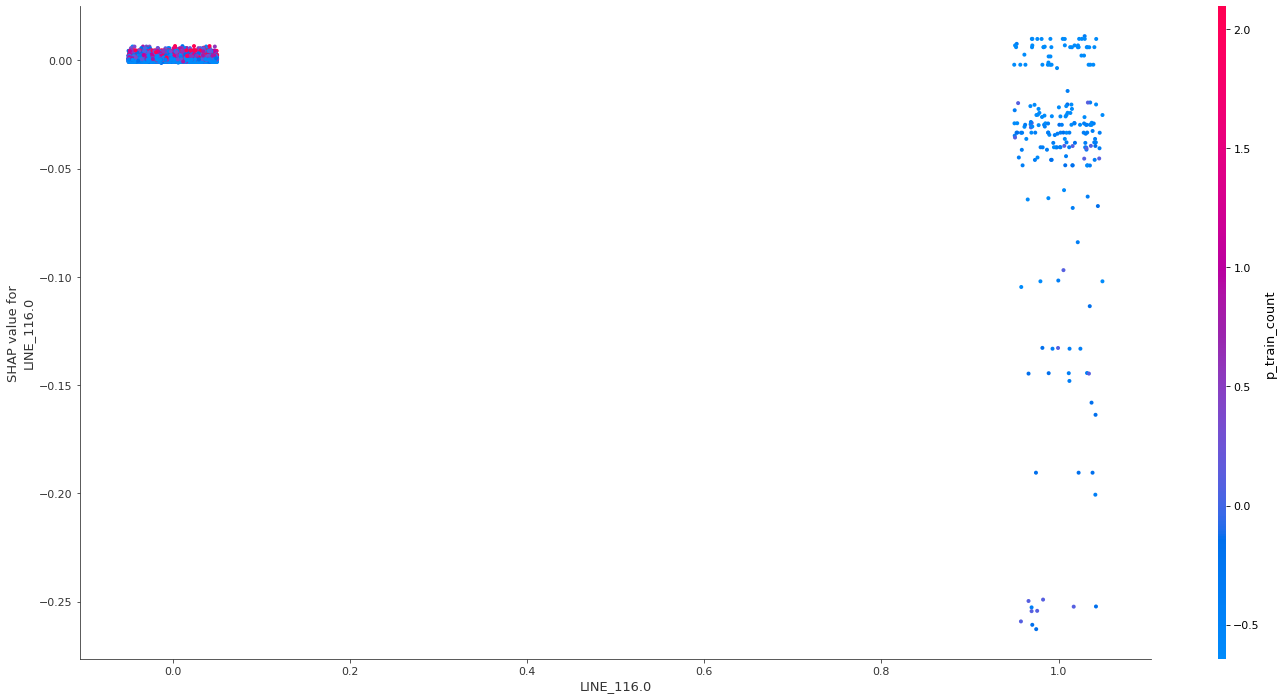

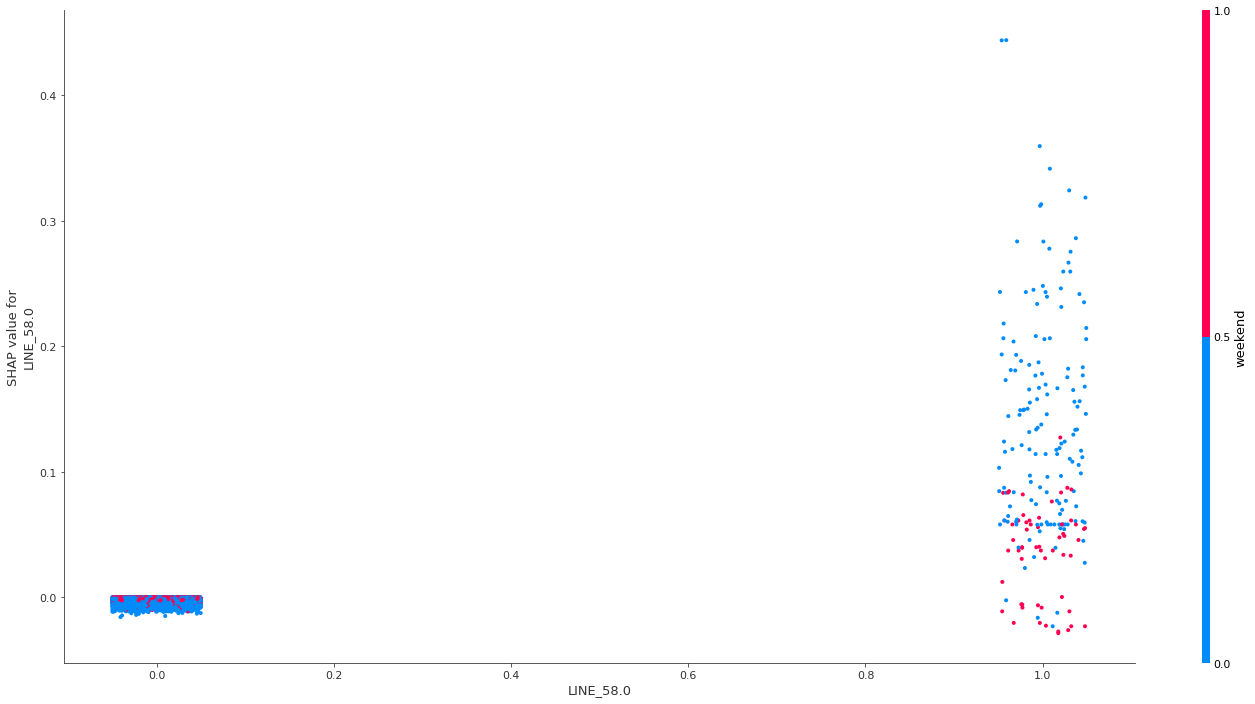

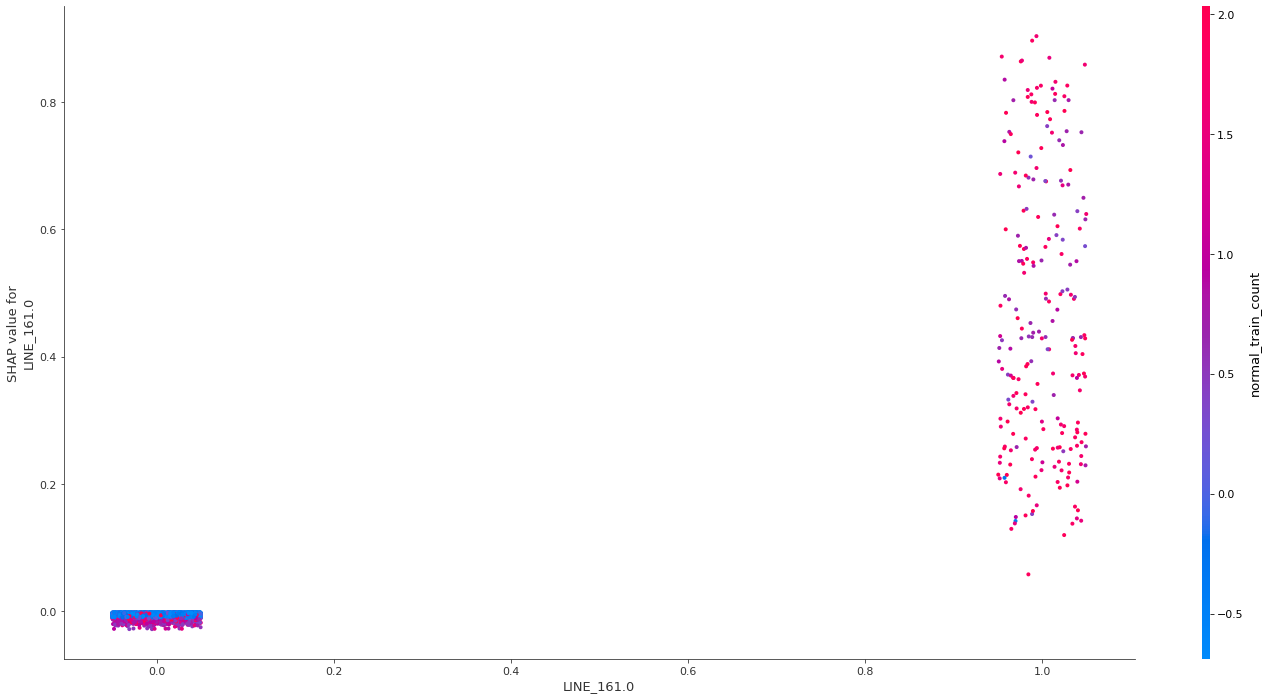

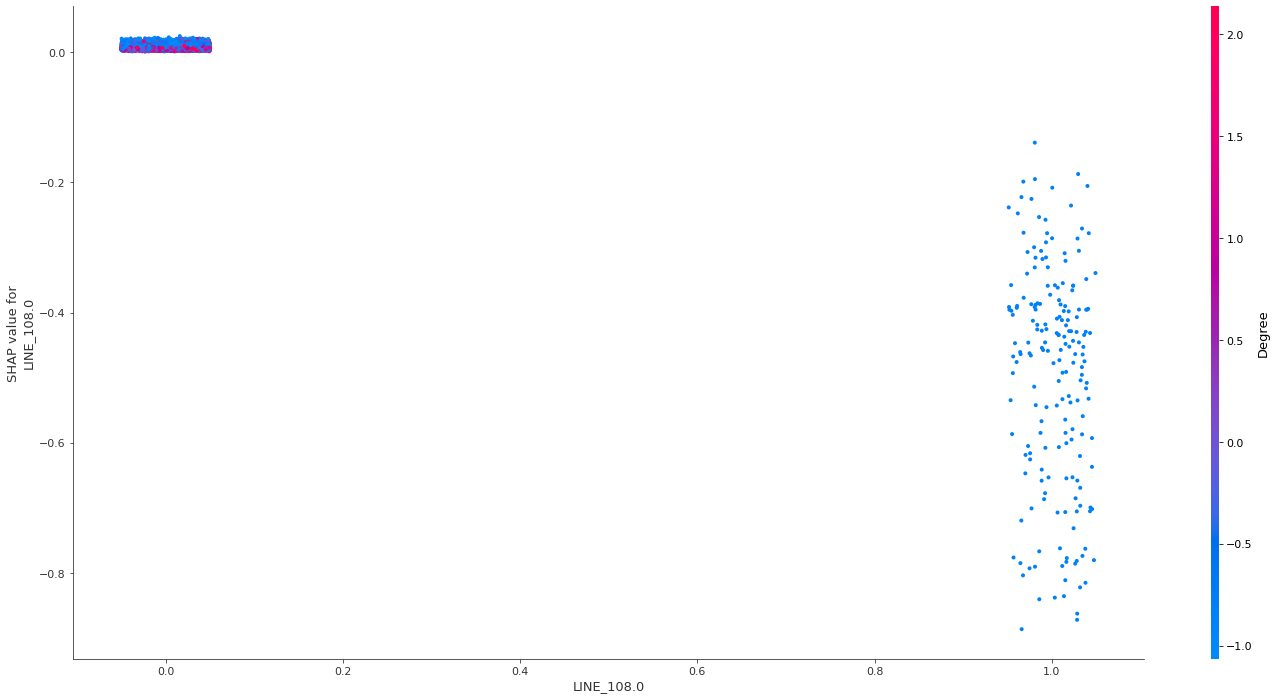

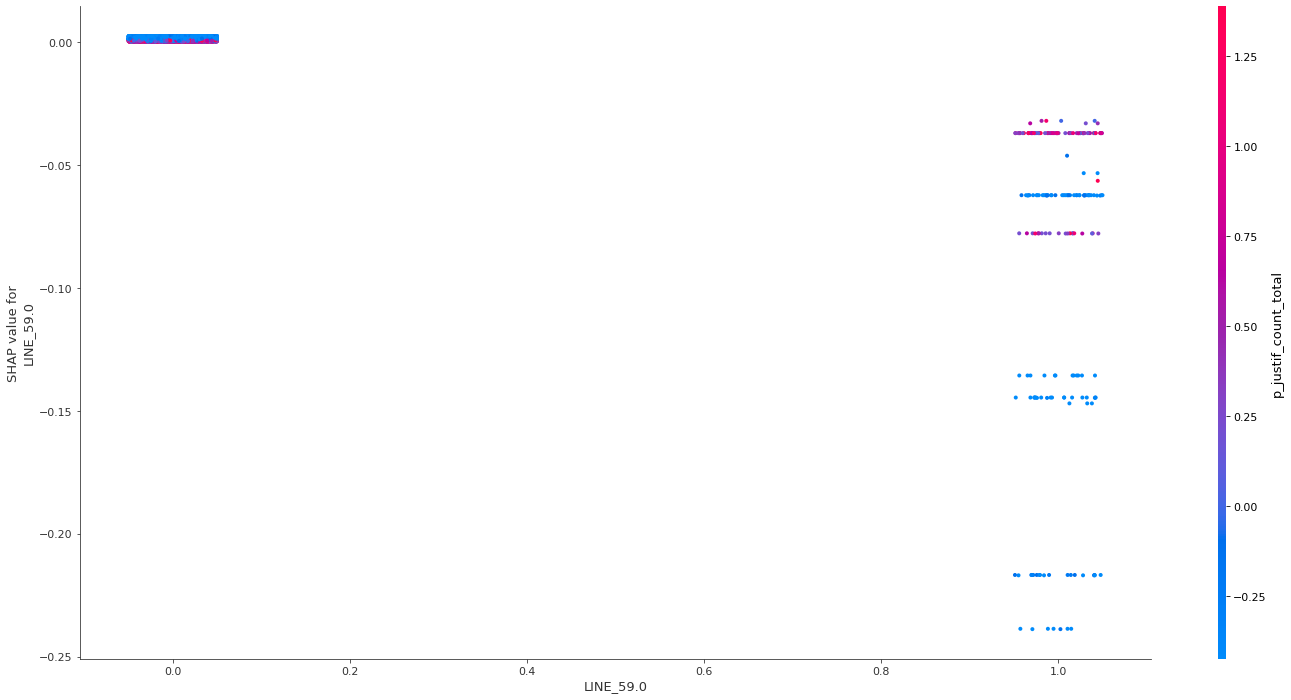

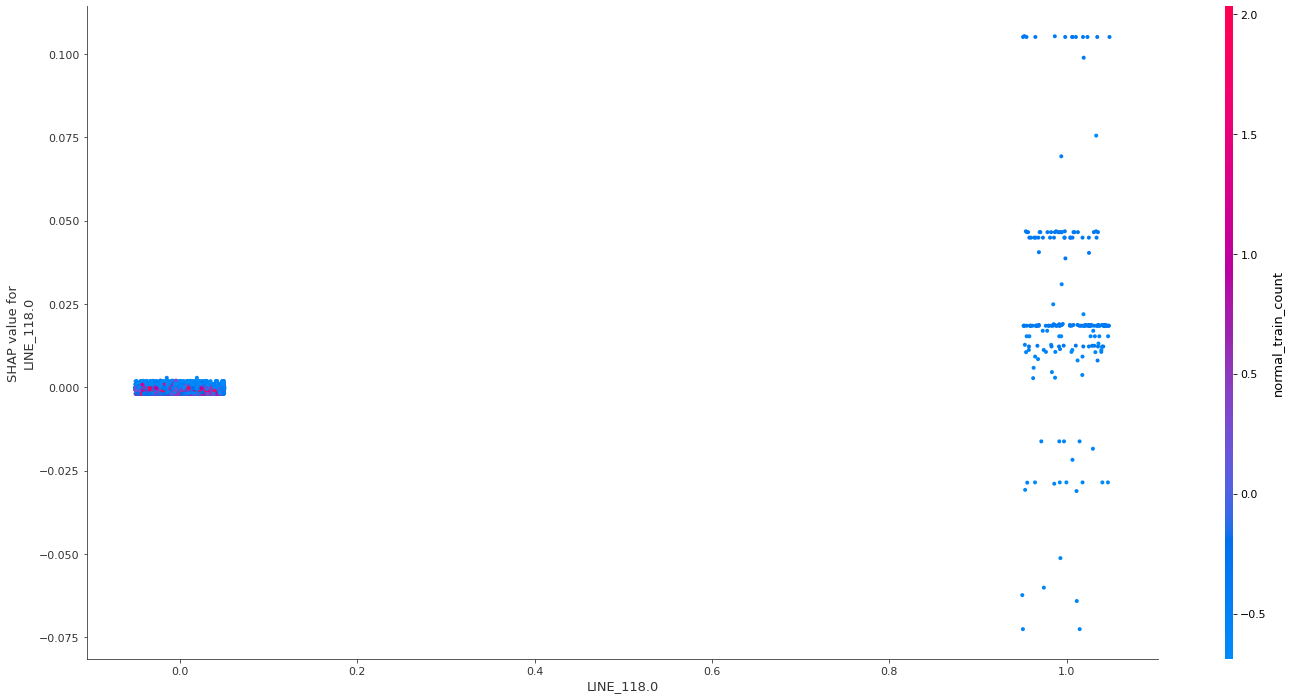

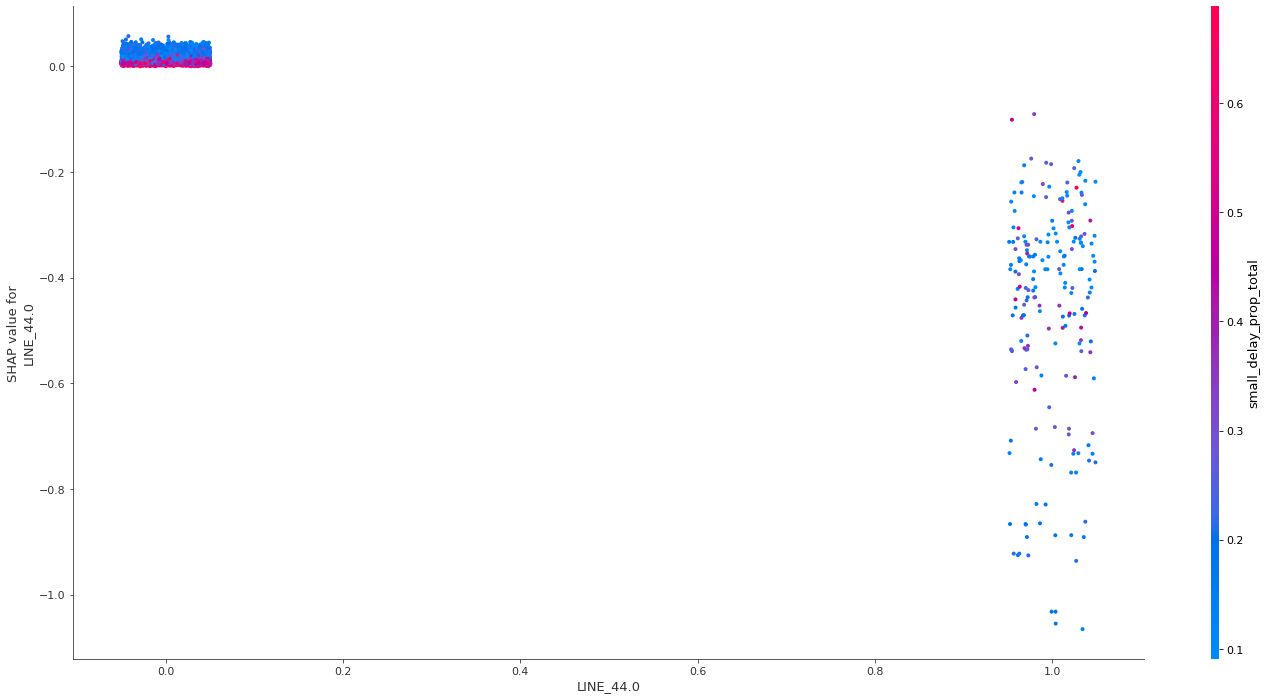

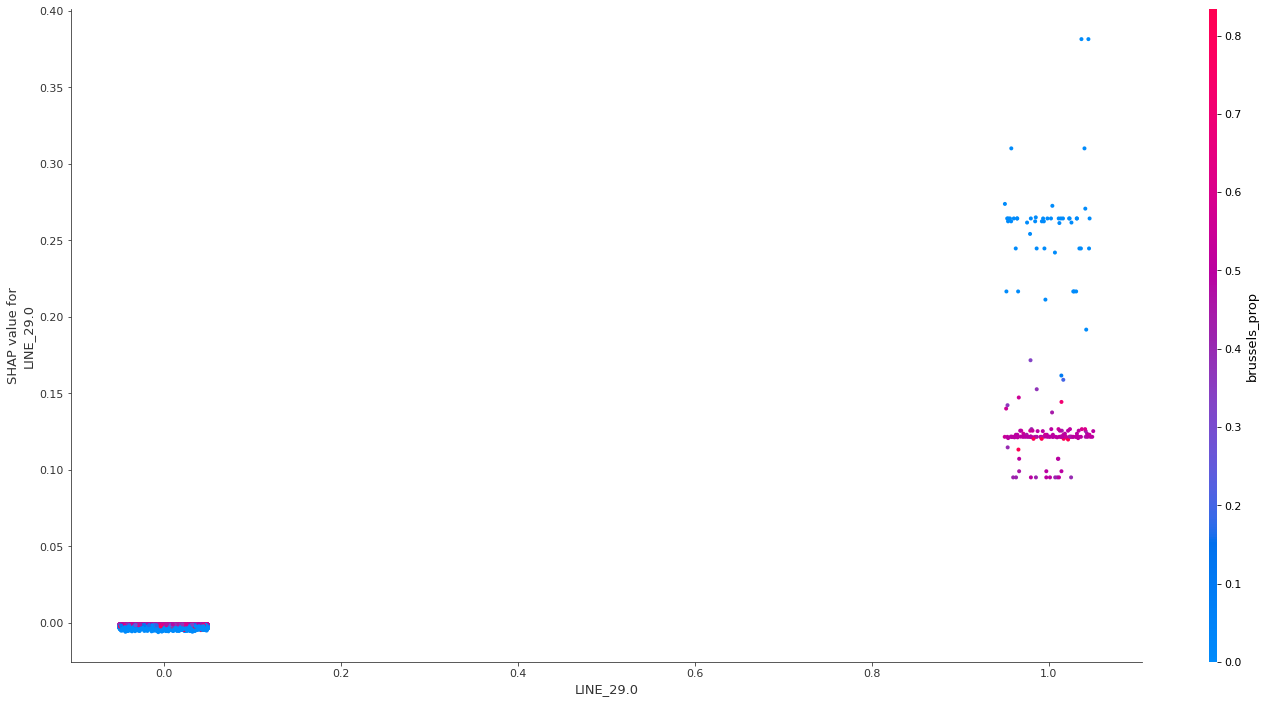

In [26]:
# check shap and interaction effects
shap_values = explainer.shap_values(X_test)
top_20_feats = X_train.columns[sorted_indices][:20]

for feat_name in top_20_feats:
    shap.dependence_plot(f"{feat_name}", shap_values, X_test, show = False, x_jitter = .1)

    plt.gcf().set_size_inches(24, 12)
    # Show the plot
    plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


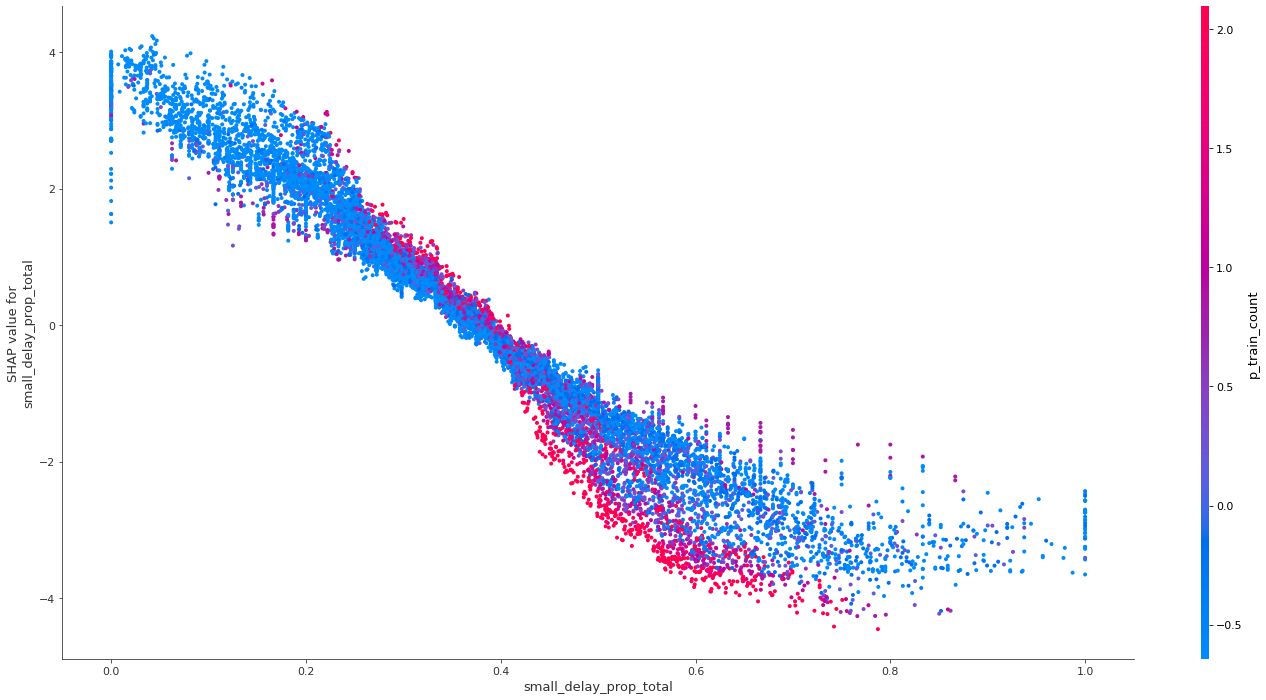

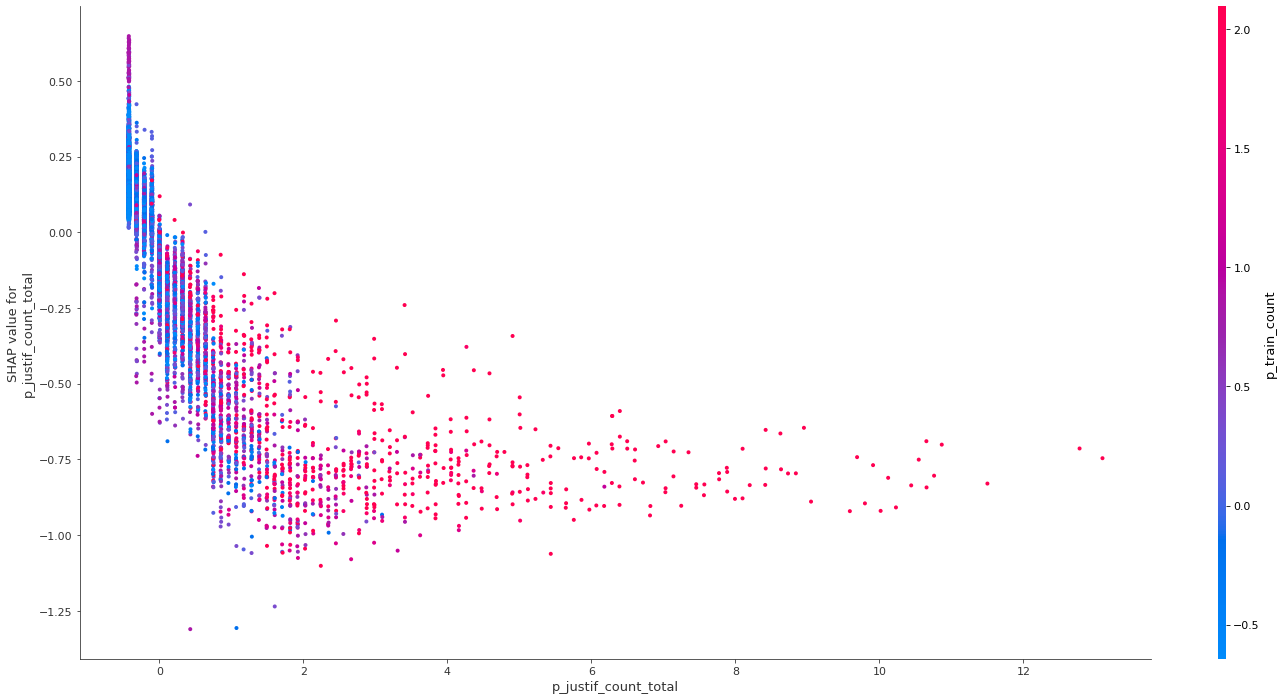

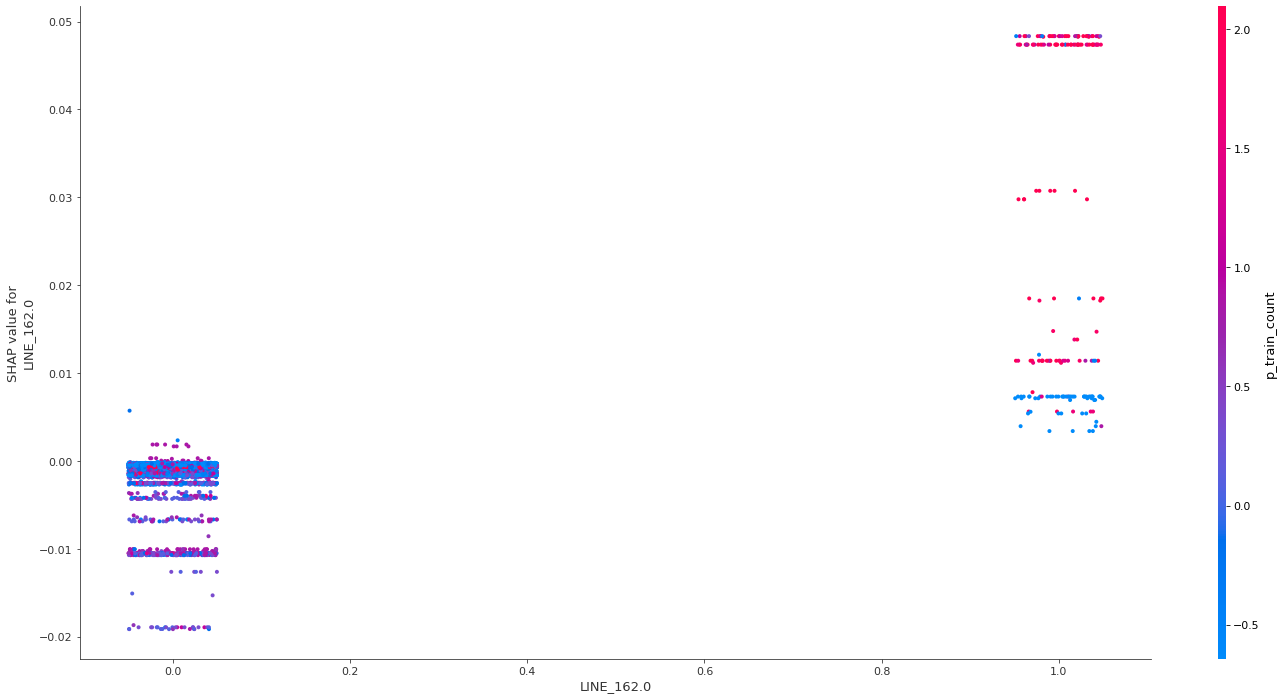

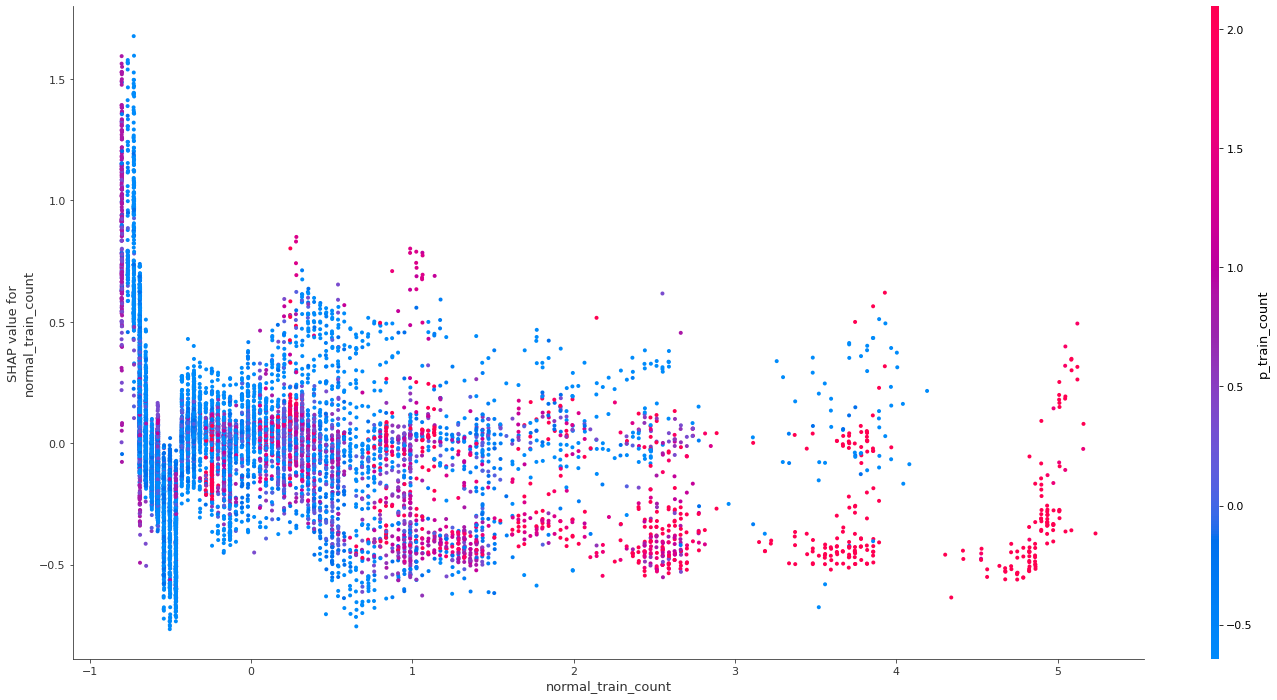

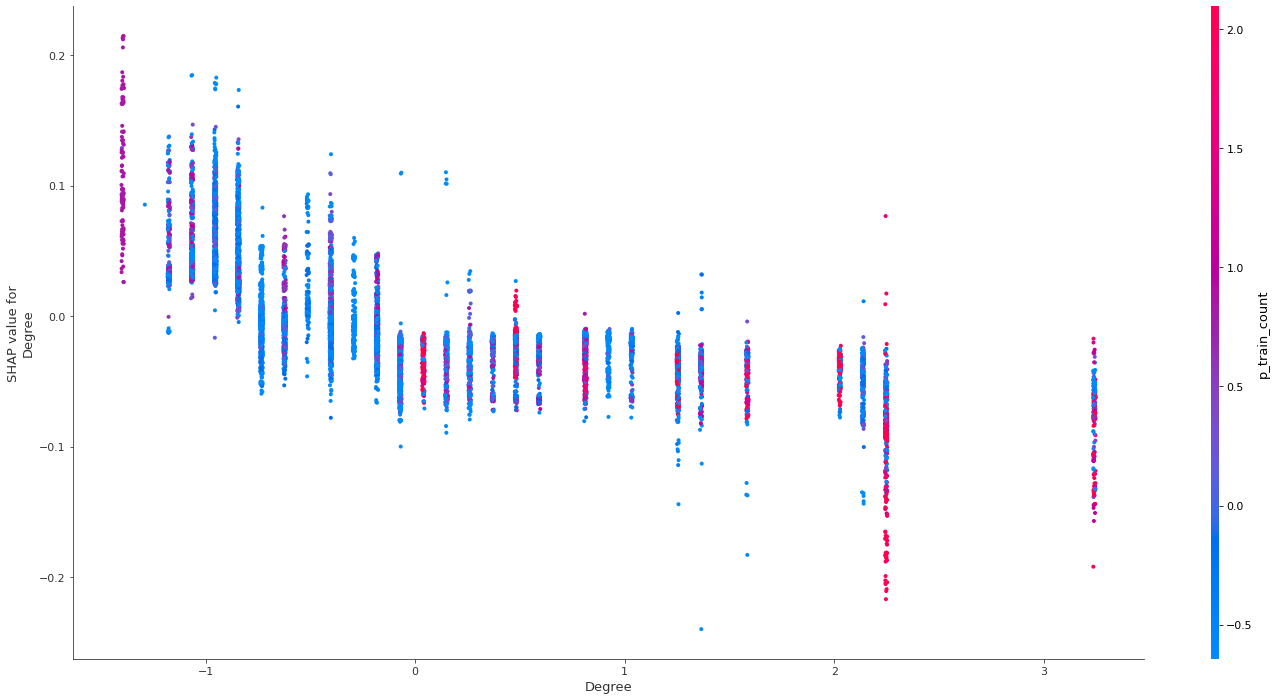

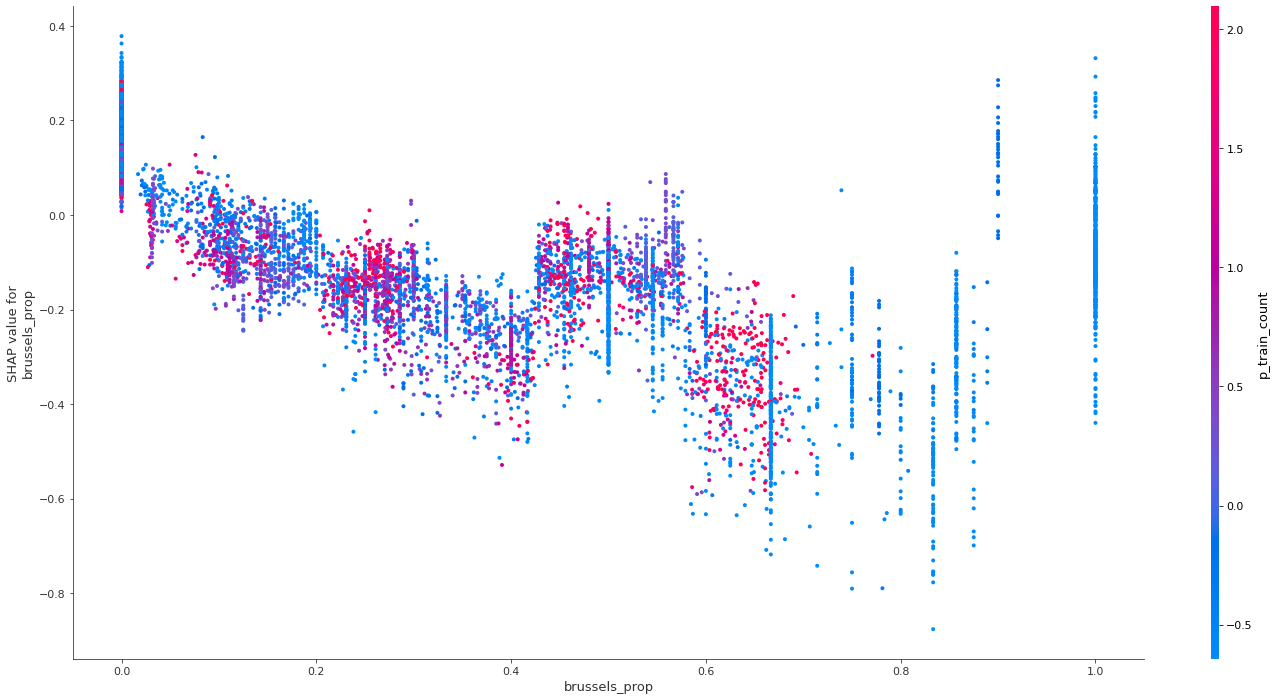

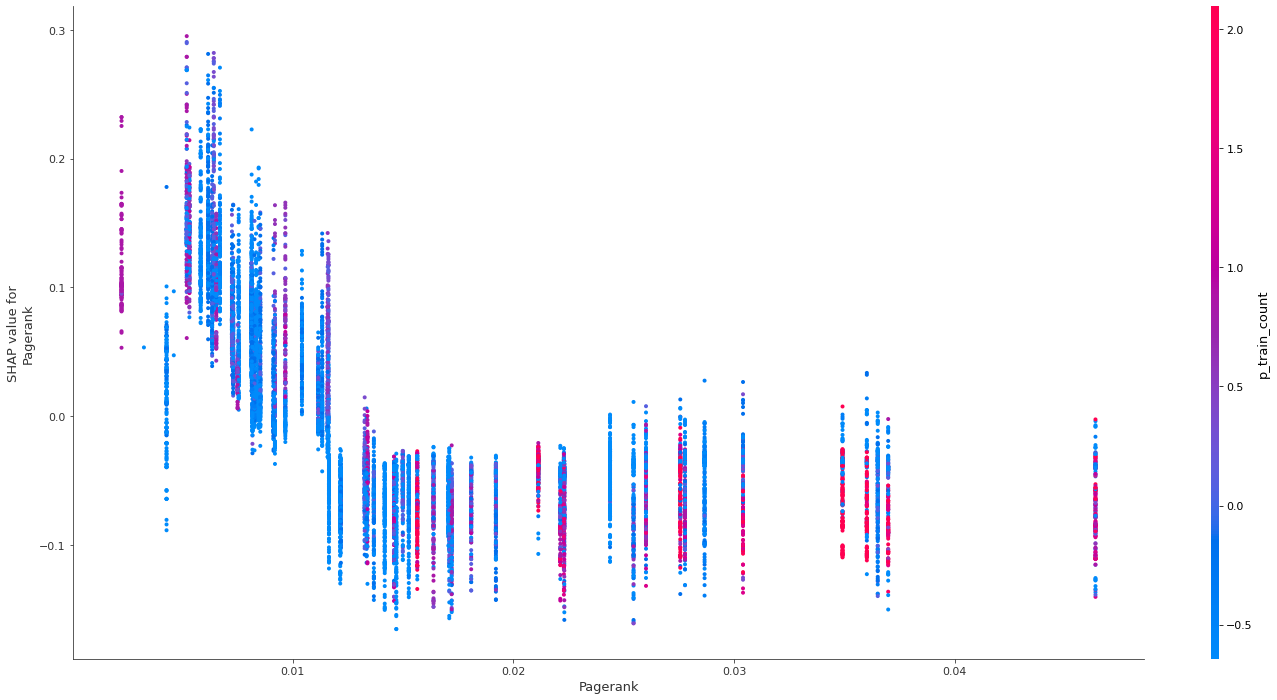

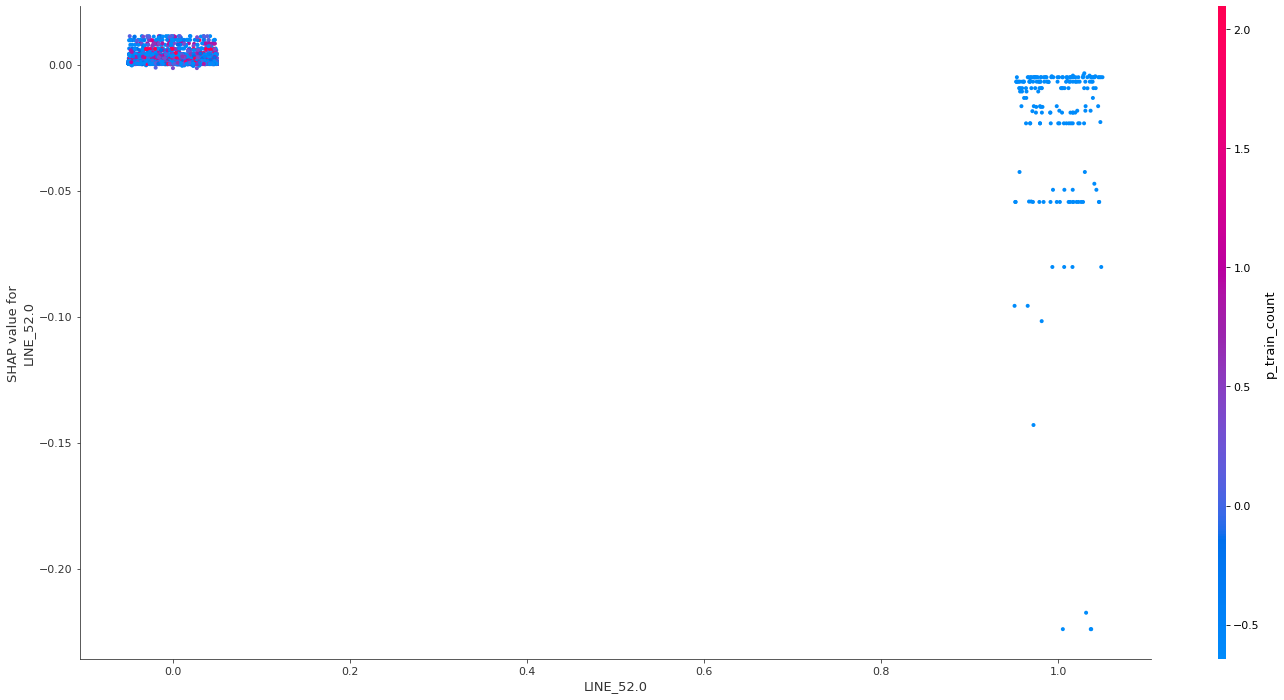

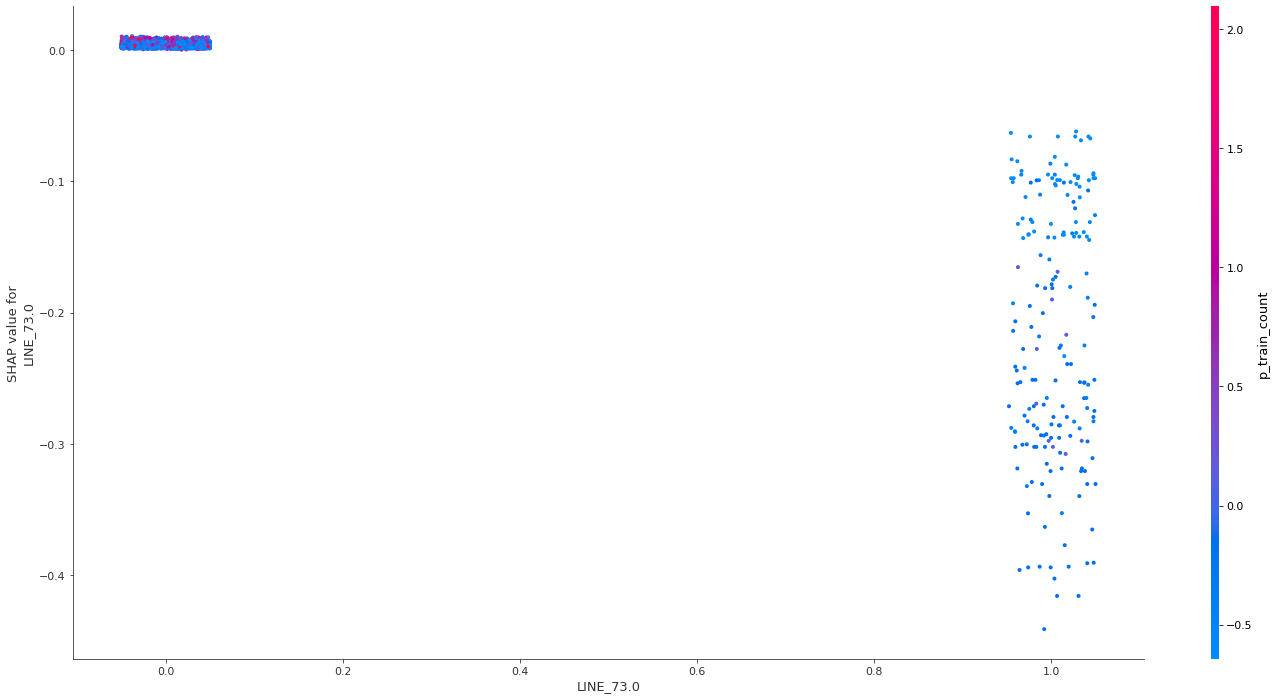

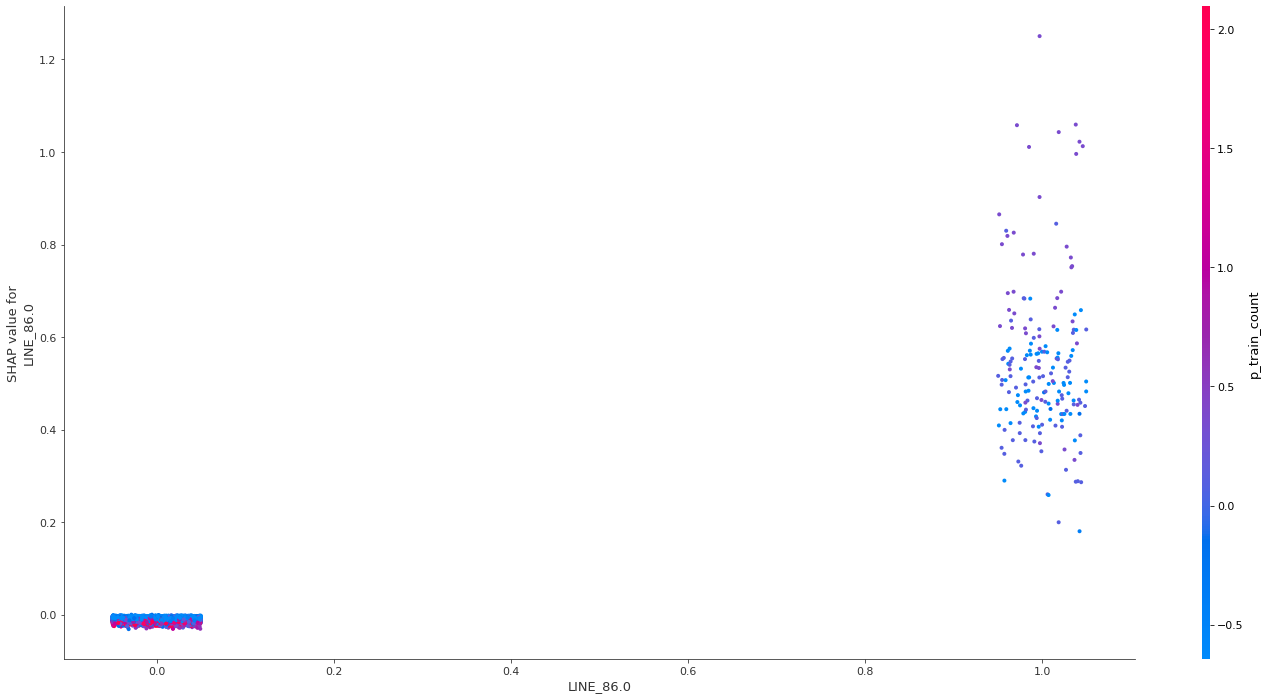

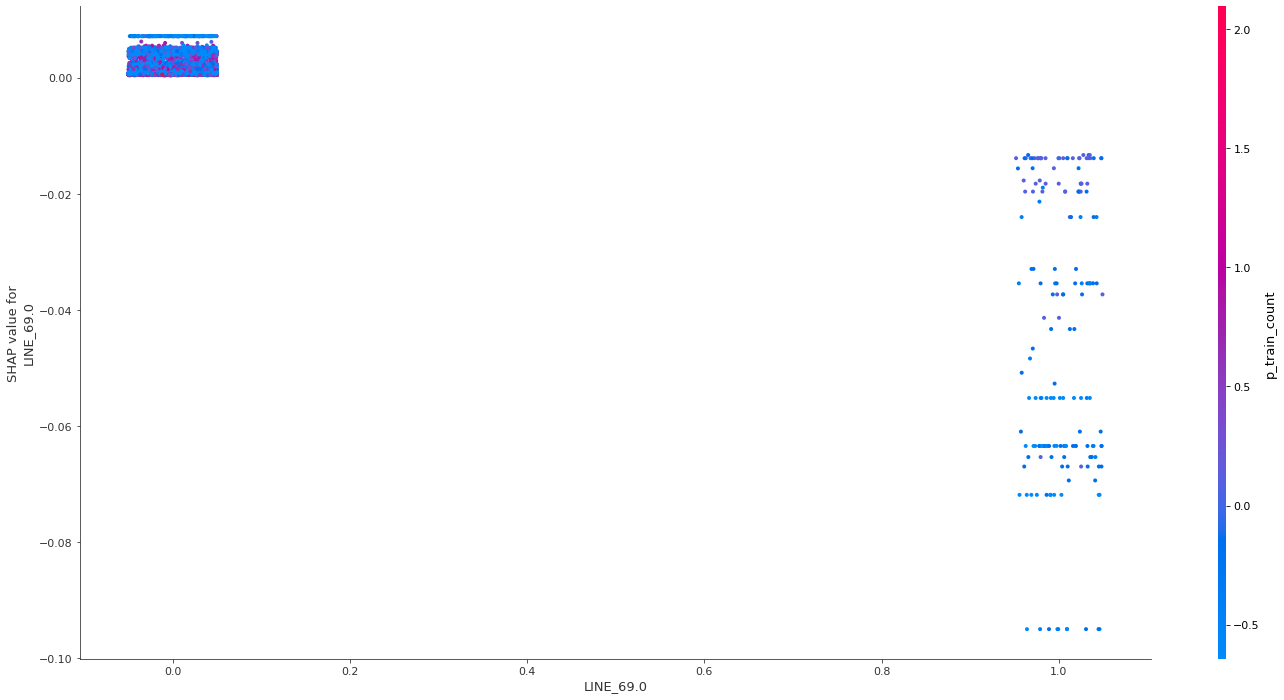

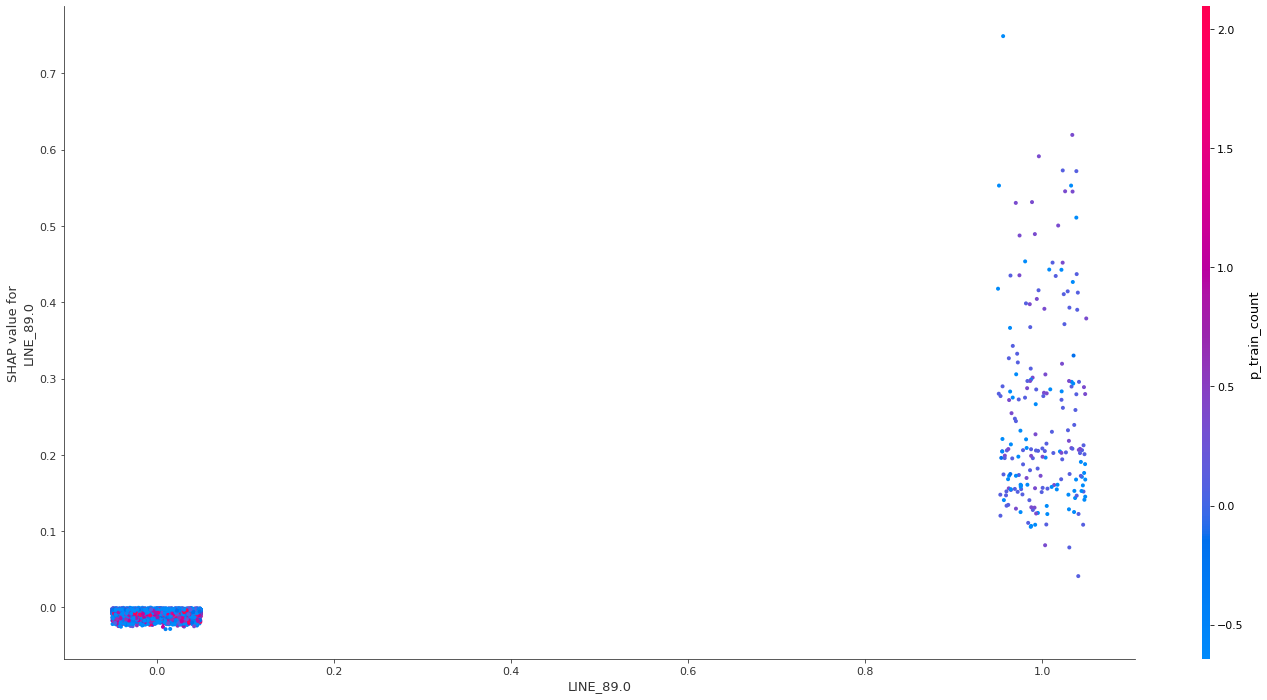

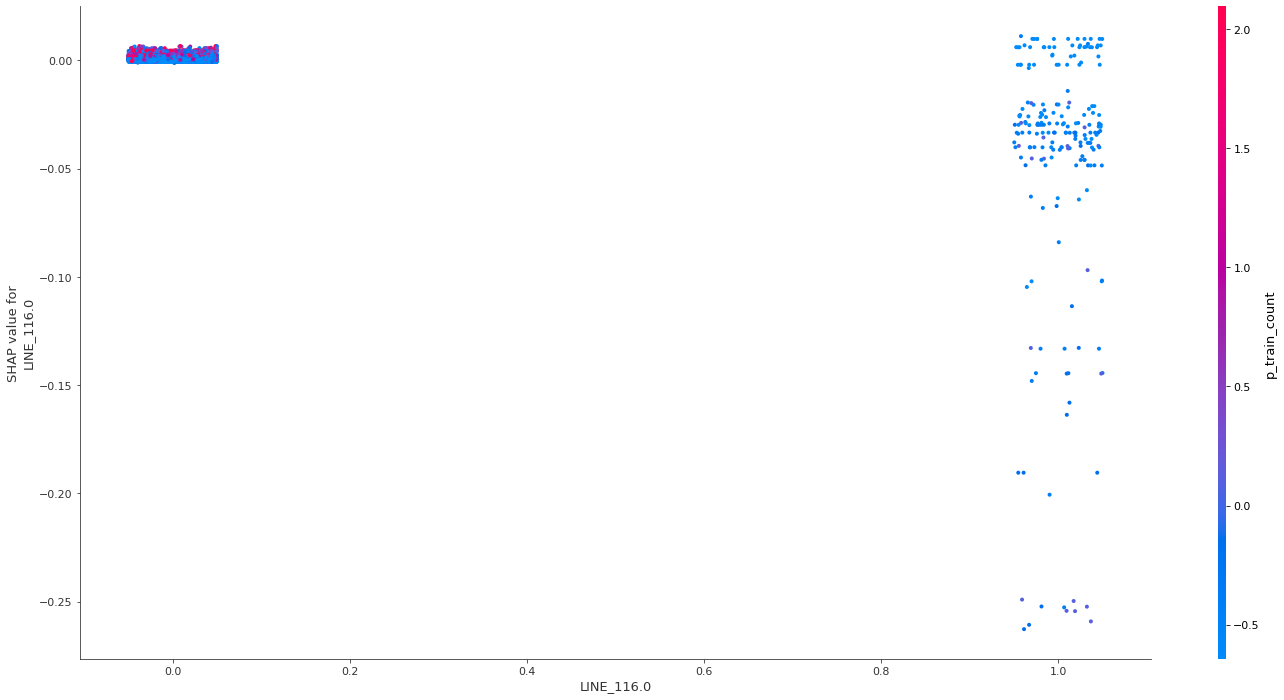

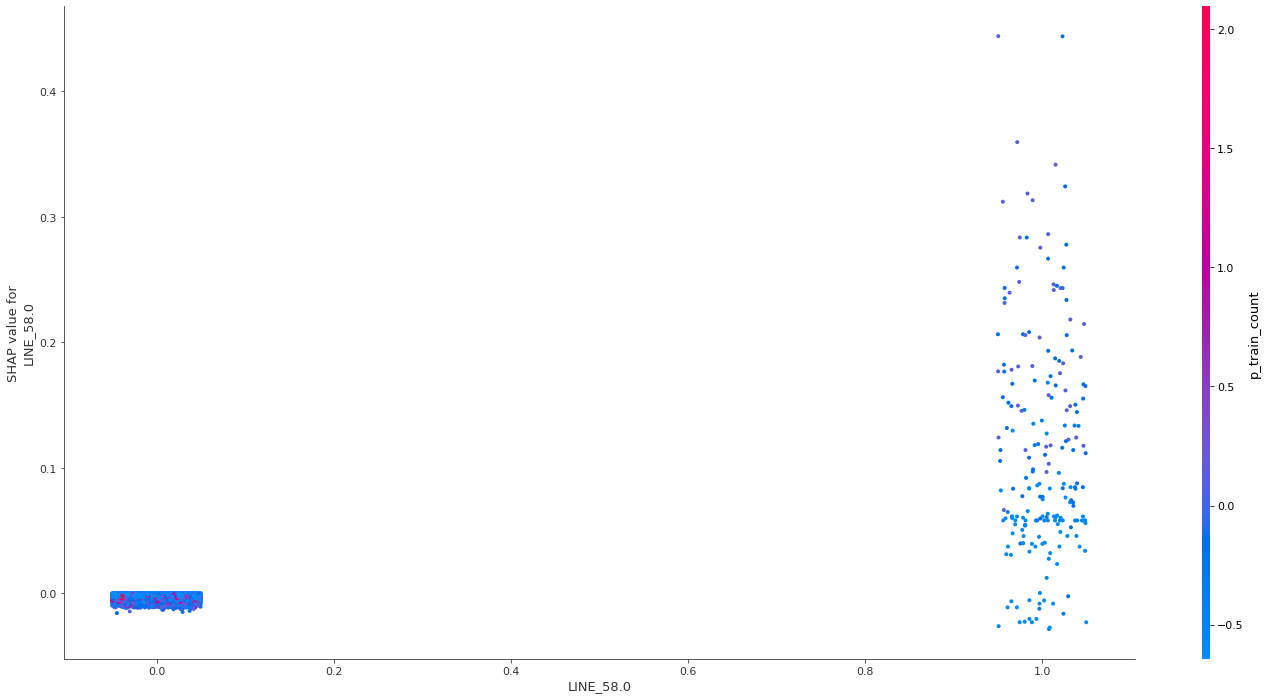

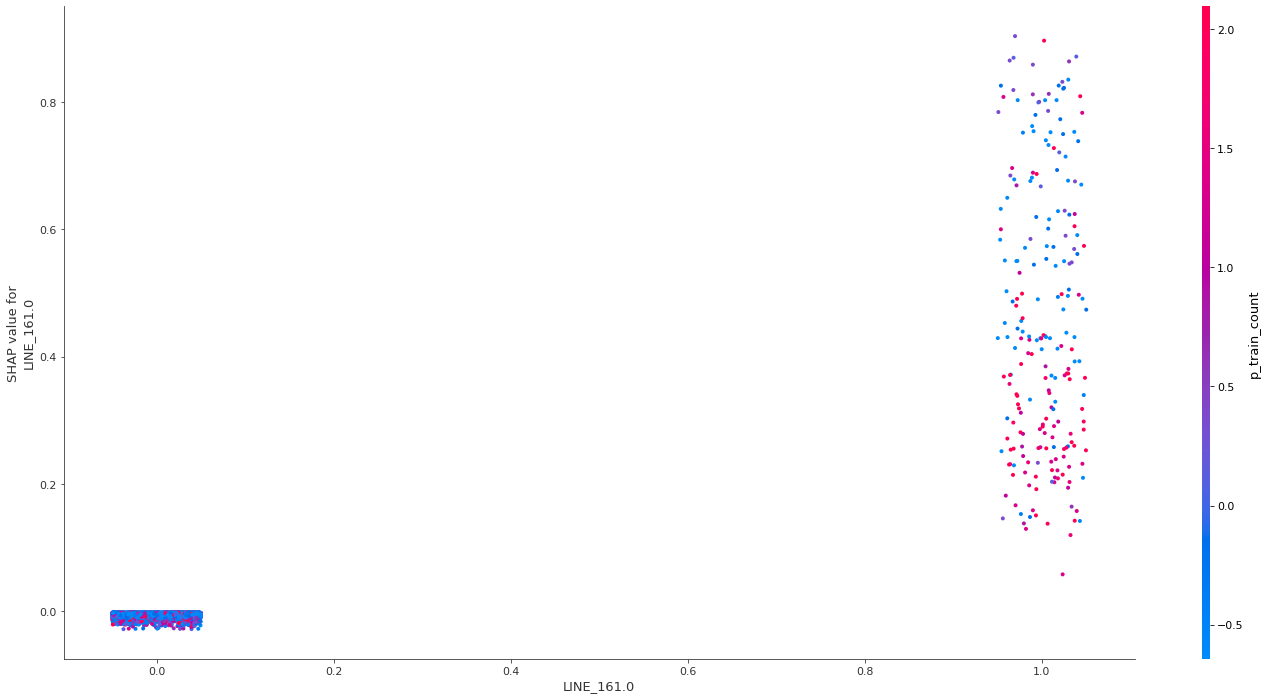

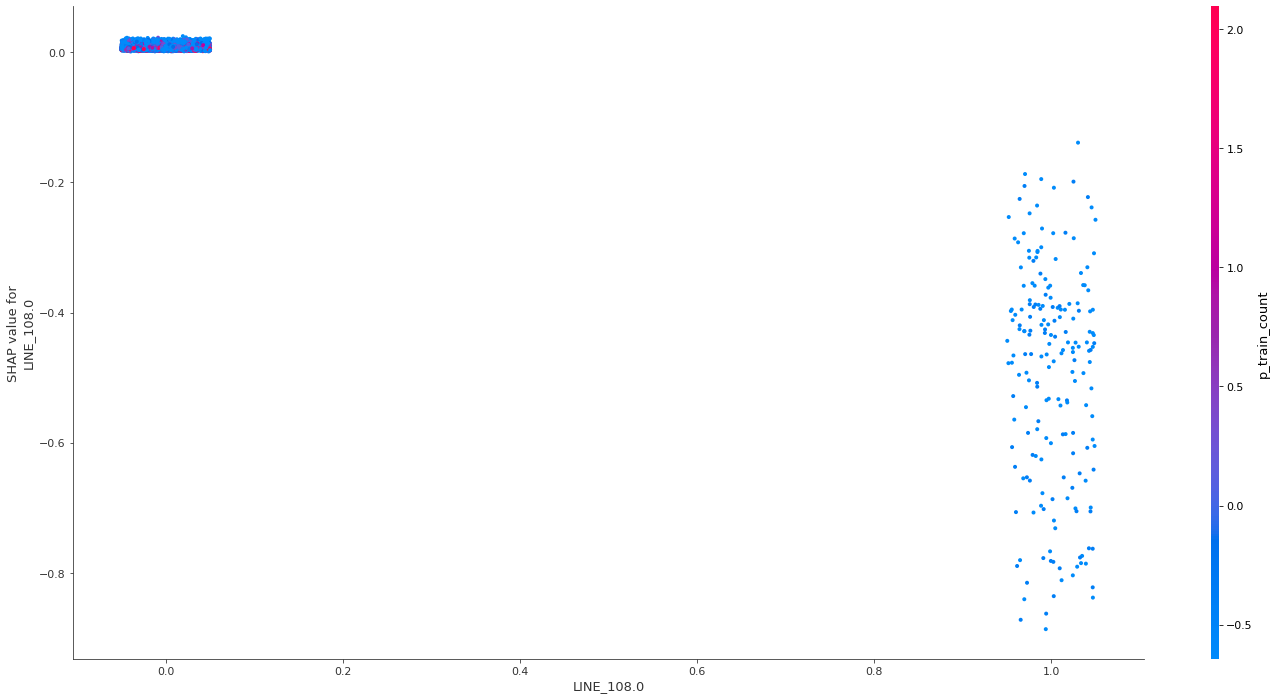

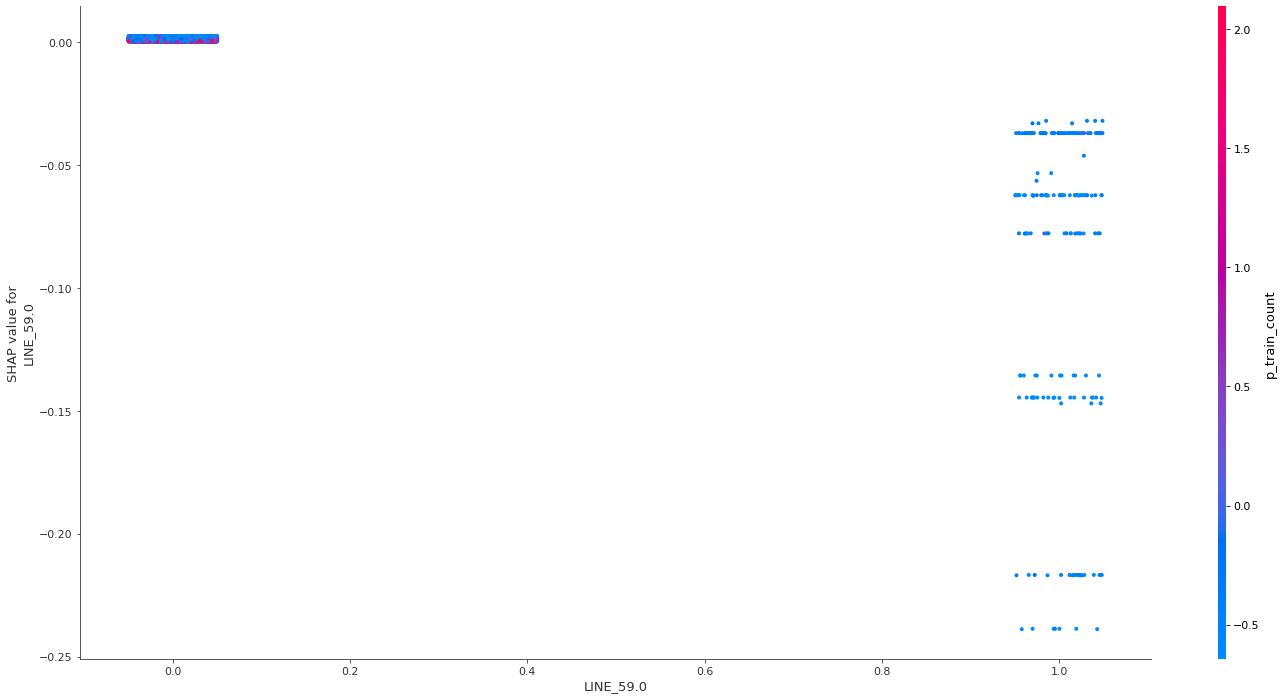

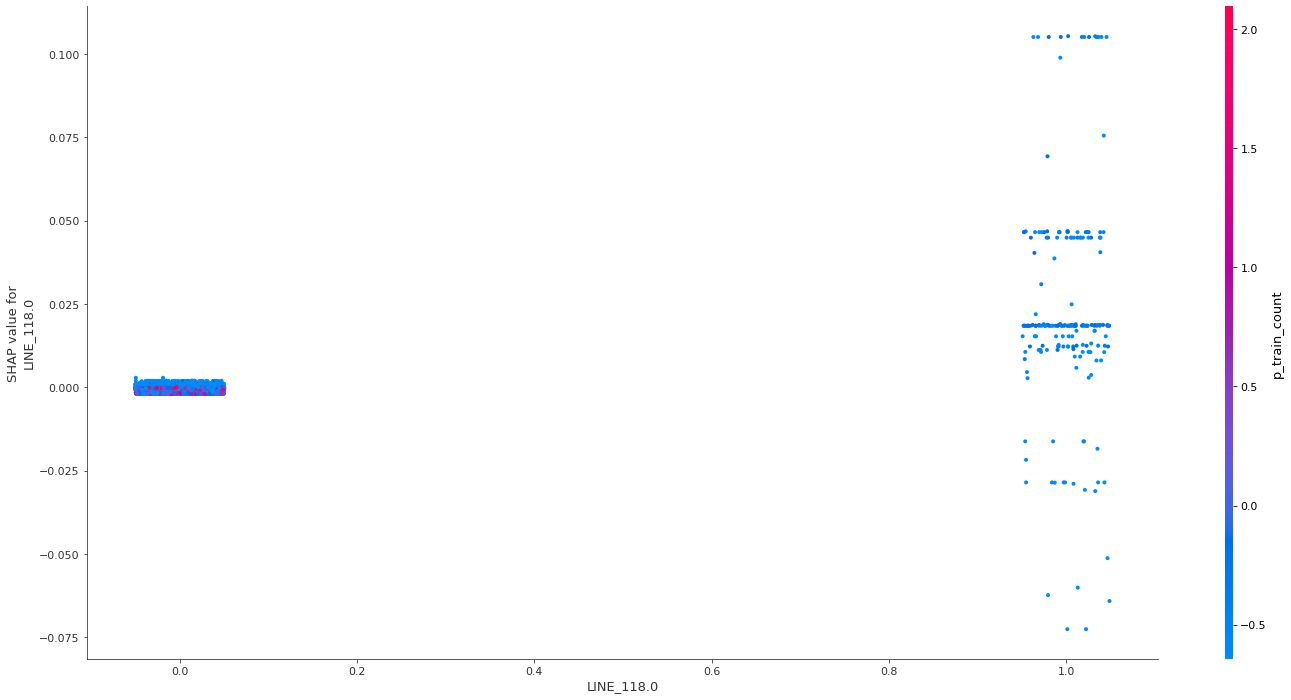

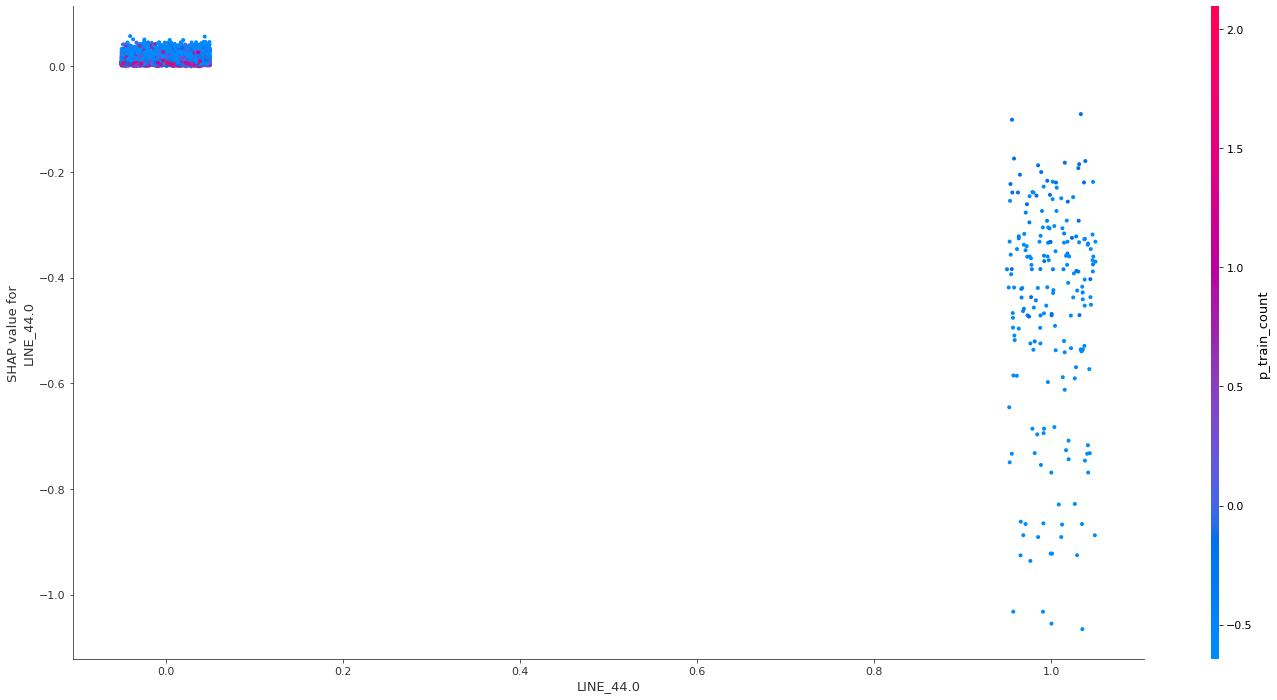

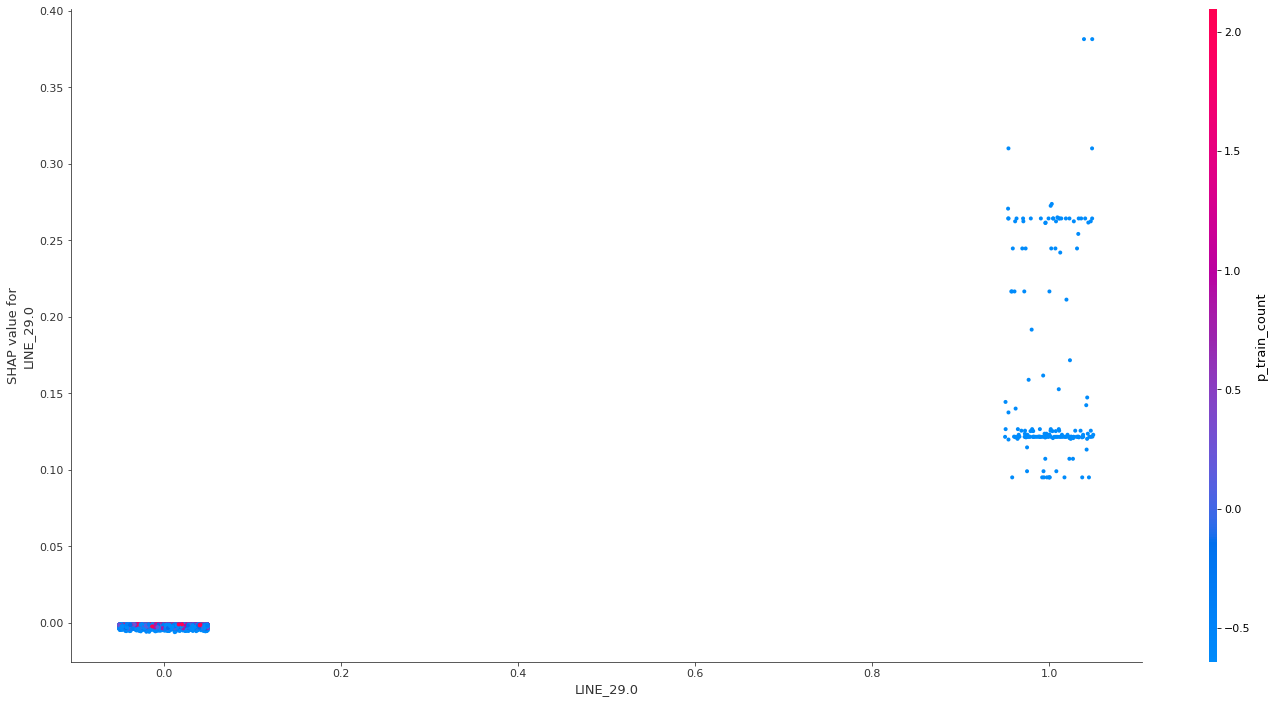

In [27]:
# check shap and interaction effects
shap_values = explainer.shap_values(X_test)
top_20_feats = X_train.columns[sorted_indices][:20]

for feat_name in top_20_feats:
    shap.dependence_plot(f"{feat_name}", shap_values, X_test, interaction_index='p_train_count', show = False, x_jitter = .1) #p_justif_count_total

    plt.gcf().set_size_inches(24, 12)
    # Show the plot
    plt.show()